In [1]:
import os
import sys
sys.path.append("/home/ksavevska/talos_ws/dmpbbo")
import dmpbbo.json_for_cpp as jc
from dmpbbo.dmps.Trajectory import Trajectory
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pytransform3d.rotations import quaternion_integrate, matrix_from_quaternion, plot_basis
import copy
import quaternion
from dtaidistance import dtw

In [2]:
plt.rcParams.update({"text.usetex": True,
              "font.family": "serif",
              "font.serif": ["Computer Modern Roman"], 
              "font.weight": "medium",
              "font.style": "normal",
              "font.size": 14,
              "figure.figsize": [4.9, 3.5],
              "axes.linewidth": 0.4})

In [81]:
cop_x = cv[:, -15]
cop_y = cv[:, -15+1]

rf_y = cv[0, -2]                                                            
lf_y = cv[0, -5]                       
rf_x = cv[0, -3]
lf_x = cv[0, -6]


ref_cop = np.array([(rf_x + lf_x)/2, (rf_y + lf_y)/2])

ref_cop

array([100., 100.])

In [82]:
def calculate_dist_to_cop(cost_vars):                        
    n_misc = 15                                                                                         
    if len(cost_vars[:,-n_misc][cost_vars[:,-n_misc]==100]) == 1:
        print("yes")
        cost_vars = cost_vars[:-1,:]
    cop_x = cost_vars[:,-n_misc]                                  
    cop_y = cost_vars[:,-n_misc+1]
    

    rf_y = cost_vars[0, -2]                                                            
    lf_y = cost_vars[0, -5]                       
    rf_x = cost_vars[0, -3]
    lf_x = cost_vars[0, -6]             
    ref_cop = np.array([(rf_x + lf_x)/2, (rf_y + lf_y)/2])
    if ref_cop[0] == 100.0 and ref_cop[1] == 100:
        ref_cop = np.array([0.0, 0.0])
    dist_to_cop = np.sum((1/len(cop_x))*np.sqrt((cop_x - ref_cop[0])**2 + (cop_y - ref_cop[1])**2))
    return dist_to_cop


def plot_costs(results_folder, subplots=False, plot=False):
    updates = np.sort(os.listdir(results_folder))
    with open(results_folder + '/plot_configs.json') as config_file:
        plot_configs = json.load(config_file)
    
    costs = []
    dist_to_cop = []
    for update in updates:
        if "update0" in update and update != "update00150":
            cost_files = np.sort(os.listdir(os.path.join(results_folder, update)))
            for cost in cost_files:
                if "eval_costs.txt" in cost:
                    c = np.loadtxt(os.path.join(results_folder+update, cost))
                    costs.append(c)
                    cv = np.loadtxt(results_folder+update+"/eval_cost_vars.txt")
                    d=calculate_dist_to_cop(cv)                                                    
                    dist_to_cop.append(d)
    columns = plot_configs["weights"].keys()
#     columns = ["cost", "stab_cost", "goal_cost", "orient_cost", "acc_cost", "traj_cost"]
#     columns = ["cost", "stab_cost", "goal_cost", "orient_cost", "acc_cost"]

    res = pd.DataFrame(columns=columns, data=costs)
#     task = jc.loadjson(results_folder + "task.json")
#     task_weights = {"stab_cost": task["stability_weight_"], "goal_cost": task["goal_weight_"], \
#                     "orient_cost": task["goal_orientation_weight_"], "traj_cost": task["traj_weight_"], \
#                     "acc_cost": task["acc_weight_"]}
#     res["cost"] = 0
#     for col in res.columns:
#         if col!="cost":
#             res["cost"] += res[col]/task_weights[col]
#     res["cost"] = cost
    res["stab_cost"] = dist_to_cop

    weights = plot_configs["weights"]
    titles = plot_configs["titles"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray", "black"]
    if "stab_cost" not in weights.keys():
            weights["stab_cost"] = 1.0
            titles["stab_cost"] = "Distance from CSP"

    if subplots:
        fig, axs = plt.subplots(1, len(columns), figsize=(4.9*len(columns), 3.5))
        for i, col in enumerate(res.columns):
            if len(res[col][res["cost"]<10]) < len(res)/2:
                axs[i].plot(res[col][res["cost"]<10]/weights[col], color=colors[i])
            else:
                axs[i].plot(res[col]/weights[col], color=colors[i])
            
            axs[i].set_title(titles[col])
            axs[i].grid()
        if plot:
            plt.show()
    else:
        for i, col in enumerate(res.columns):
            if plot:
                plt.plot(res[col]/weights[col], color=colors[i])
                plt.title(titles[col])
                plt.grid()
                # plt.savefig(results_folder+"/"+titles[col]+".pdfc", dpi=1000, format="pdf", bbox_inches='tight')
                plt.savefig(results_folder+"/"+titles[col]+".jpg")

                plt.show()
                                                           
    return res

In [26]:
def plot_ee_traj(results_folder):
    cost_vars_0 = np.loadtxt(results_folder + "/update00000/eval_cost_vars.txt")
    cost_vars_T = np.loadtxt(results_folder + "/update00149/eval_cost_vars.txt")
    n_misc = 15
    n=0
    m=-1
    ee_pos_x_0 = cost_vars_0[n:m,-n_misc+2]
    ee_pos_y_0 = cost_vars_0[n:m,-n_misc+3]
    ee_pos_z_0 = cost_vars_0[n:m,-n_misc+4]
    pos_0 = np.column_stack((ee_pos_x_0, ee_pos_y_0, ee_pos_z_0))
    ee_rot_x_0 = cost_vars_0[n:m,-n_misc+5]
    ee_rot_y_0 = cost_vars_0[n:m,-n_misc+6]
    ee_rot_z_0 = cost_vars_0[n:m,-n_misc+7]
    ee_rot_w_0 = cost_vars_0[n:m,-n_misc+8]
    Q_0 = np.column_stack((ee_rot_w_0, ee_rot_x_0, ee_rot_y_0, ee_rot_z_0))
    
    ee_pos_x_T = cost_vars_T[n:m,-n_misc+2]
    ee_pos_y_T = cost_vars_T[n:m,-n_misc+3]
    ee_pos_z_T = cost_vars_T[n:m,-n_misc+4]
    pos_T = np.column_stack((ee_pos_x_T, ee_pos_y_T, ee_pos_z_T))
    ee_rot_x_T = cost_vars_T[n:m,-n_misc+5]
    ee_rot_y_T = cost_vars_T[n:m,-n_misc+6]
    ee_rot_z_T = cost_vars_T[n:m,-n_misc+7]
    ee_rot_w_T = cost_vars_T[n:m,-n_misc+8]
    Q_T = np.column_stack((ee_rot_w_T, ee_rot_x_T, ee_rot_y_T, ee_rot_z_T))
    
    fig3d = plt.figure(figsize=(10,6))
    # ax = Axes3D(fig3d)
    ax = fig3d.add_subplot(111, projection="3d")
    ax.view_init(None, 220)
    n=0
    ax.plot(ee_pos_x_0[n:], ee_pos_y_0[n:], ee_pos_z_0[n:], linewidth=1.5, label="initial")
    ax.plot(ee_pos_x_T[n:], ee_pos_y_T[n:], ee_pos_z_T[n:], linewidth=1.5, label="optimal")
    ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
    # for i in [-1]:
    #     R_0 = matrix_from_quaternion(Q_0[i])
    #     p_0 = pos_0[i]
    #     R_T = matrix_from_quaternion(Q_T[i])
    #     p_T = pos_T[i]
    #     ax = plot_basis(ax=ax, s=0.05, R=R_0, p=p_0)
    #     ax = plot_basis(ax=ax, s=0.05, R=R_T, p=p_T)
    # ax = plot_basis(ax=ax, s=0.05, R=matrix_from_quaternion([0.5, 0.5, -0.5, -0.5]), p=[0.65,-0.4, 0.0])

    ax.legend(loc="upper right")
    ax.set_title("EE trajectory comparison")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")    
    # plt.savefig(results_folder+"/ee_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
    plt.savefig(results_folder+"/ee_traj_comparison.jpg")
    
    plt.show()
    return ' '

In [5]:
def plot_dmps(results_folder):
    dmp_0 = jc.loadjson(results_folder + "/updates_rarm/update00000/eval_dmp.json")
    ts_rarm = dmp_0.ts_train
    xs, xds, forcing, fa_outputs, q_traj = dmp_0.analytical_solution()
    traj_sample = dmp_0.states_as_trajectory(ts_rarm, xs, xds)

    dmp_T = jc.loadjson(results_folder + "/updates_rarm/update00149/eval_dmp.json")
    ts_rarm = dmp_T.ts_train
    xs, xds, forcing, fa_outputs, q_traj = dmp_T.analytical_solution()
    traj_sample_T = dmp_T.states_as_trajectory(ts_rarm, xs, xds)

    dmp_traj = np.column_stack((traj_sample.ys, traj_sample.yds, traj_sample.ydds))
    dmp_traj_T = np.column_stack((traj_sample_T.ys, traj_sample_T.yds, traj_sample_T.ydds))

    plt.rcParams['axes.grid'] = True
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
    ax[0,0].plot(dmp_traj[:,0], label="initial", color="red", linestyle="--")
    ax[0,0].plot(dmp_traj_T[:,0], label="optimal", color="red", linestyle="-")
    ax[0,0].set_ylabel("x")
    ax[0,0].set_title("Position")
    ax[0,0].legend()
    ax[1,0].plot(dmp_traj[:,1], label="initial", color="blue", linestyle="--")
    ax[1,0].plot(dmp_traj_T[:,1], label="optimal", color="blue", linestyle="-")
    ax[1,0].set_ylabel("y")
    ax[1,0].legend()
    ax[2,0].plot(dmp_traj[:,2], label="initial", color="green", linestyle="--")
    ax[2,0].plot(dmp_traj_T[:,2], label="optimal", color="green", linestyle="-")
    ax[2,0].set_ylabel("z")
    ax[2,0].legend()

    ax[0,1].plot(dmp_traj[:,3], color="red", linestyle="--")
    ax[0,1].plot(dmp_traj_T[:,3], color="red", linestyle="-")
    ax[0,1].set_title("Velocity")
    ax[1,1].plot(dmp_traj[:,4], color="blue", linestyle="--")
    ax[1,1].plot(dmp_traj_T[:,4], color="blue", linestyle="-")
    ax[2,1].plot(dmp_traj[:,5], color="green", linestyle="--")
    ax[2,1].plot(dmp_traj_T[:,5], color="green", linestyle="-")

    ax[0,2].plot(dmp_traj[:,6], color="red", linestyle="--")
    ax[0,2].plot(dmp_traj_T[:,6], color="red", linestyle="-")
    ax[0,2].set_title("Acceleration")
    ax[1,2].plot(dmp_traj[:,7], color="blue", linestyle="--")
    ax[1,2].plot(dmp_traj_T[:,7], color="blue", linestyle="-")
    ax[2,2].plot(dmp_traj[:,8], color="green", linestyle="--")
    ax[2,2].plot(dmp_traj_T[:,8], color="green", linestyle="-")
    fig.suptitle("DMP initial vs optimal comparison", fontweight="bold")
    
    plt.show()


In [56]:
# plt.rcParams.update({'font.size': 20})#, "font.weight": "normal", "axes.labelweight": "normal"})
def plot_cop(results_folder):
    updates = [results_folder + "update00000/",
#                results_folder + "update00049/",
#                results_folder + "update00099/",
               results_folder + "update00149/"]
    cost_varss = [np.loadtxt(update+"eval_cost_vars.txt") for update in updates]
    labels = ["initial", "optimal"]

    n_misc = 15
        
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray", "black"]
    fig = plt.figure(figsize=(6,4))#figsize=(30*cm,20*cm))

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    for i, cost_vars in enumerate(cost_varss):
        # Calculate borders of the support polygon
        x_size = 0.21
        y_size = 0.13
        sp_y_1 = cost_vars[0, -2] - y_size/2
        sp_y_2 = cost_vars[0, -5] + y_size/2
        sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
        sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
        
        # Calculate middle point from the borders as ref_cop
        # ref_cop_ = [(sp_x_1 + sp_x_2) / 2, (sp_y_1 + sp_y_2) / 2]

        # Get the actual COP moved to match 
        cop_y = copy.copy(cost_vars[:,-n_misc+1])
        cop_x = copy.copy(cost_vars[:,-n_misc])
        # cop_x -= ref_cop_[0]
        # cop_y -= ref_cop_[1]

        df = pd.DataFrame(data=np.array([cop_x, cop_y]).T, columns=["x", "y"])
        

        n=0
        ax1.plot(df['x'].iloc[n:].rolling(1,1).mean(), df['y'].iloc[n:].rolling(1,1).mean(), label=labels[i], linewidth=1.2)
#         ax1.plot(df['x'].iloc[n:].rolling(30,1).mean(), df['y'].iloc[n:].rolling(30,1).mean(), label="Update "+str(i*50), linewidth=1.2)
        # ax1.scatter(df['x'].iloc[n::10].rolling(30,1).mean(), df['y'].iloc[n::10].rolling(30,1).mean(), label="Update "+str(i*50), s=10)

        ts = np.array(range(0, len(cost_vars)))/120
        ax2.plot(ts[n:], cop_x[n:], color=colors[i], linewidth=1.5)
        ax3.plot(ts[n:], cop_y[n:], color=colors[i], linewidth=1.5)

    x_size = 0.21
    y_size = 0.13
    sp_y_1 = cost_vars[0, -2] - y_size/2
    sp_y_2 = cost_vars[0, -5] + y_size/2
    sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
    sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
    
    ax2.plot(ts[n:], [sp_x_1]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.plot(ts[n:], [sp_x_1+x_size]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.set_ylabel("x")
    ax2.set_xlabel("[s]")
    ax2.set_xlim([ts[n], ts[-1]])
        

    ax3.plot(ts[n:], [sp_y_1]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.plot(ts[n:], [sp_y_2]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.set_ylabel("y")
    ax3.set_xlabel("[s]")
    ax3.set_xlim([ts[n], ts[-1]])

    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.add_patch(plt.Rectangle((sp_x_1, sp_y_1), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))

    ax1.add_patch(plt.Rectangle(( sp_x_1, sp_y_2-y_size), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))
    ax1.text(-0.06, sp_y_2-y_size/2-0.01, "left foot", color="gray")
    ax1.text(-0.06, sp_y_1+y_size/2, "right foot", color="gray")

    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax1.hlines(sp_y_1, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.hlines(sp_y_2, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.vlines(sp_x_1,        ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    ax1.vlines(sp_x_1+x_size, ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    
    ax1.set_ylim([-0.25,0.25])
    # ax1.set_xlim([-0.1,0.15])


    ax1.legend(loc="lower left", fontsize=14)#, bbox_to_anchor=(1, 0.5))
    # ax1.locator_params(axis='x', nbins=5)
    ax1.locator_params(axis='y', nbins=5)
    ax2.locator_params(axis='x', nbins=5)
    # ax2.locator_params(axis='y', nbins=5)
    ax3.locator_params(axis='x', nbins=5)
    # ax3.locator_params(axis='y', nbins=5)
    fig.suptitle("ZMP trajectory comparison")
    fig.tight_layout()
    # fig.savefig(results_folder + "/zmp_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
    fig.savefig(results_folder + "/zmp_traj_comparison.jpg")

    plt.show()
    return ' '

In [7]:
def plot_exploration_curve(results_folder):
    n_updates = 150
    updates = np.sort([update for update in os.listdir(results_folder) if "update0" in update])
    curve = np.zeros((n_updates, 2))
    for i_update in range(n_updates):
        distribution = jc.loadjson(results_folder + updates[i_update] + "/distribution.json")
        cur_exploration = np.sqrt(distribution.max_eigen_value())
        curve[i_update, 0] = i_update * 30
        curve[i_update, 1] = cur_exploration

    return curve

In [8]:
def calculate_traj_cost(result, traj_demonstrated_):
    
    updates = np.sort([update for update in os.listdir(result) if "update0" in update and update != "update00150"])
    n_dims = 18
    traj_cost = []
    for update in updates:
        cost_vars = np.loadtxt(result+"/"+update+"/eval_cost_vars.txt")
        joint_states = cost_vars[:,:n_dims]
        if (joint_states[-1] == 100).any():
            traj_cost.append(10)
        else:
            traj_cost.append(np.sum([dtw.distance(joint_states[:,i], traj_demonstrated_.ys[:, i]) for i in range(joint_states.shape[1])]) / joint_states.shape[1])
    return traj_cost

In [9]:
def calculate_acc_cost(result):
    updates = np.sort([update for update in os.listdir(result) if "update0" in update and update != "update00150"])
    n_dims = 18
    acc_costs = []
    for update in updates:
        dmp = jc.loadjson(result+"/"+update+"/eval_dmp.json")
        ts = dmp.ts_train
        xs, xds, forcing, fa_outputs = dmp.analytical_solution()
        traj = dmp.states_as_trajectory(ts, xs, xds)
        acc_filtered = traj.ydds
        acc_sums = np.array([np.sum(acc_filtered[:,a]**2)/len(acc_filtered[:,a]) for a in range(acc_filtered.shape[1])])
        acc_cost = np.sum(acc_sums)/len(acc_sums)
        acc_costs.append(acc_cost)
    return acc_costs

In [21]:
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

def compare_costs(results, weights_stability, output_dir, save=True):
    dfs = []
    weights = []
    titles = []
    task_weights = []
    for result in results:
        df = plot_costs(result, plot=False)
#         if result != results[0]:
#             df[df["cost"]>=10] = np.nan
#             df.ffill(inplace=True)
        if "traj_cost" not in df.columns:
            trajectory = Trajectory.loadtxt("trajectories/trajectory.txt")
            df["traj_cost"] = calculate_traj_cost(result, trajectory)
        if "acc_cost" not in df.columns:
            df["acc_cost"] = calculate_acc_cost(result)
        
        with open(result + '/plot_configs.json') as config_file:
            plot_configs = json.load(config_file)
        weights.append(plot_configs["weights"])
        titles.append(plot_configs["titles"])
        dfs.append(df)
    units = [" ", "[m]", "[m]", "[rad]", " ", " "]
    for i, col in enumerate(weights[-1].keys()):
        plt.figure()
        for j, res in enumerate(dfs):
            if col in weights[j].keys():
                w = weights[j][col]
            else:
                w = 1
#             plt.plot(res[col][res["cost"]<10]/w, label=r"$w_{stab} = $"+r"$"+str(weights_stability[j])+"$")
            if len(res[col][res["cost"]<10]) > len(res)/2:
                plt.plot(res[col][res["cost"]<10]/w, label=weights_stability[j])
            else:
                plt.plot(res[col]/w, label=weights_stability[j])
    
            
#             plt.title(titles[-1][col])
        plt.grid()
        if i == 0:
            legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncols=4, columnspacing=0.8)
            export_legend(legend, filename=output_dir + "/legend.pdf")
            legend.remove()
        plt.ylabel(units[i])
        plt.xlabel("Updates")
        plt.xlim([0,150])
        plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
        if save:
            plt.savefig(output_dir + "/" +titles[j][col]+".pdf", dpi=1000, format="pdf")#, bbox_inches='tight')
#             plt.savefig(results_folder+"/"+titles[col]+".jpg")

        plt.show()

In [36]:
def compare_zmps(results, weights, output_dir, save=True):
    cost_varss = [np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars.txt")]
    for result in results:
        cost_varss.append(np.loadtxt(result+"update00149/eval_cost_vars.txt"))
    
    labels = ["initial"]
    for weight in weights:
#         labels.append(r"$w_{traj} = $"+str(weight))
        labels.append(weight)
        
    n_misc = 15
        
    colors = ["black", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]
    fig = plt.figure(figsize=(6,4))#figsize=(30*cm,20*cm))

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    for i, cost_vars in enumerate(cost_varss):
        # Calculate borders of the support polygon
        x_size = 0.21
        y_size = 0.13
        sp_y_1 = cost_vars[0, -2] - y_size/2
        sp_y_2 = cost_vars[0, -5] + y_size/2
        sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
        sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
        
        # Calculate middle point from the borders as ref_cop
        ref_cop_ = [(sp_x_1 + sp_x_2) / 2, (sp_y_1 + sp_y_2) / 2]

        # Get the actual COP moved to match 
        cop_y = copy.copy(cost_vars[:,-n_misc+1])
        cop_x = copy.copy(cost_vars[:,-n_misc])
        cop_x -= ref_cop_[0]
        # cop_y -= ref_cop_[1]

        df = pd.DataFrame(data=np.array([cop_x, cop_y]).T, columns=["x", "y"])
        
        n=0
        ax1.plot(df['x'], df['y'], label=labels[i], color=colors[i], linewidth=1.0)
#         ax1.plot(df['x'].iloc[n:].rolling(10,1).mean(), df['y'].iloc[n:].rolling(10,1).mean(), label=labels[i], color=colors[i], linewidth=1.2)
        # ax1.scatter(df['x'].iloc[n::10].rolling(30,1).mean(), df['y'].iloc[n::10].rolling(30,1).mean(), label="Update "+str(i*50), s=10)

        ts = np.array(range(0, len(cost_vars)))/120
        ax2.plot(ts[n:], cop_x[n:], color=colors[i], linewidth=1.0)
        ax3.plot(ts[n:], cop_y[n:], color=colors[i], linewidth=1.0)

    x_size = 0.21
    y_size = 0.13
    sp_y_1 = cost_vars[0, -2] - y_size/2
    sp_y_2 = cost_vars[0, -5] + y_size/2
    sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
    sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
    
    sp_x_1 = -x_size/2
    sp_x_2 = x_size/2
    
    ax2.plot(ts[n:], [sp_x_1]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.plot(ts[n:], [sp_x_1+x_size]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.set_ylabel("x")
    ax2.set_xlabel("[s]")
    ax2.set_xlim([ts[n], ts[-1]])
        

    ax3.plot(ts[n:], [sp_y_1]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.plot(ts[n:], [sp_y_2]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.set_ylabel("y")
    ax3.set_xlabel("[s]")
    ax3.set_xlim([ts[n], ts[-1]])

    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.add_patch(plt.Rectangle((sp_x_1, sp_y_1), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))

    ax1.add_patch(plt.Rectangle(( sp_x_1, sp_y_2-y_size), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))
    ax1.text(-0.05, sp_y_2-y_size/2-0.01, "left foot", color="gray")
    ax1.text(-0.05, sp_y_1+y_size/2, "right foot", color="gray")

    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax1.hlines(sp_y_1, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.hlines(sp_y_2, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.vlines(sp_x_1,        ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    ax1.vlines(sp_x_1+x_size, ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    
    ax1.set_ylim([-0.25,0.25])
    # ax1.set_xlim([-0.1,0.15])


#     ax1.legend(loc="upper center", ncols=5, bbox_to_anchor=(0.8, 1.2))
    fig.legend(loc="upper center", ncols=5, bbox_to_anchor=(0.55, 1.1), columnspacing=0.7)
    
    # ax1.locator_params(axis='x', nbins=5)
    ax1.locator_params(axis='y', nbins=5)
    ax2.locator_params(axis='x', nbins=5)
    # ax2.locator_params(axis='y', nbins=5)
    ax3.locator_params(axis='x', nbins=5)
    # ax3.locator_params(axis='y', nbins=5)
#     fig.suptitle("ZMP trajectory comparison")
    fig.tight_layout()
    if save:
        fig.savefig(output_dir + "/zmp_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
#     fig.savefig(results_folder + "/zmp_traj_comparison.jpg")

    plt.show()

In [37]:
def compare_ee_trajs(results, weights, output_dir, save=True):
    cost_varss = [np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars.txt")]
    for result in results:
        cost_varss.append(np.loadtxt(result+"update00149/eval_cost_vars.txt"))
    
    labels = ["initial"]
    for weight in weights:
#         labels.append(r"$w_{traj} = $"+str(weight))
        labels.append(weight)
        
    
    colors = ["black", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]
    
    
    n_misc = 15
    n=0
    m=-1
    fig3d = plt.figure(figsize=(10,6))
    ax = fig3d.add_subplot(111, projection="3d")
    ax.view_init(None, 220)
    for i, cost_vars in enumerate(cost_varss):
        ee_pos_x = cost_vars[n:m,-n_misc+2]
        ee_pos_y = cost_vars[n:m,-n_misc+3]
        ee_pos_z = cost_vars[n:m,-n_misc+4]
        
        ax.plot(ee_pos_x, ee_pos_y, ee_pos_z, linewidth=1.5, color=colors[i], label=labels[i])
    ax.scatter(0.65, -0.4, 0.00, s=100, color="gray")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")  
    ax.legend()
#     ax.legend(loc="upper center", ncols=5, bbox_to_anchor=(0.5, 1.1), columnspacing=0.8, shadow=True)
    
#     ax.set_title("EE trajectory comparison")
    if save:
        plt.savefig(output_dir+"/ee_traj_comparison.pdf", format="pdf", bbox_inches='tight')
#     plt.savefig(results_folder+"/ee_traj_comparison.jpg")

    plt.show()

In [14]:
Versiondef plot_ee_trajectories(results, weights):
    cost_varss = [np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars.txt")]
    for result in results:
        cost_varss.append(np.loadtxt(result+"update00149/eval_cost_vars.txt"))
    
    labels = ["initial"]
    for weight in weights:
#         labels.append(r"$w_{traj} = $"+str(weight))
        labels.append(weight)
        
    
    colors = ["black", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]
    linewidths = [1.5, 1.0, 1.0, 1.0, 1.0]
    
    n_misc = 15
    n=0
    m=-1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.9*3, 3.5))
    for i, cost_vars in enumerate(cost_varss):
        ts = np.array(range(0, len(cost_vars[:-1])))/120
        ee_pos_x = cost_vars[n:m,-n_misc+2]
        ee_pos_y = cost_vars[n:m,-n_misc+3]
        ee_pos_z = cost_vars[n:m,-n_misc+4]
        
        ax1.plot(ts, ee_pos_x, linewidth=linewidths[i], color=colors[i], label=labels[i])
        ax2.plot(ts, ee_pos_y, linewidth=linewidths[i], color=colors[i], label=labels[i])
        ax3.plot(ts, ee_pos_z, linewidth=linewidths[i], color=colors[i], label=labels[i])
    ax1.scatter(ts[-1], 0.65, s=100, color="gray")
    ax2.scatter(ts[-1], -0.4, s=100, color="gray")
    ax3.scatter(ts[-1], 0.00, s=100, color="gray")
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")  
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.legend()
    fig.suptitle("EE trajectories comparison")
#     plt.savefig(output_dir+"/ee_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
#     plt.savefig(results_folder+"/ee_traj_comparison.jpg")

    plt.show()

In [15]:
def convergence_speed(result):
    df = plot_costs(result)
    
    threshold = 0.2*df["cost"].iloc[0]
    update = 0
    for i in range(len(df)):
        if df["cost"].iloc[i] <= threshold:
            update = i
            break
    return update


In [16]:
def reaching_errors(results, weights_):

#     df_errors = pd.DataFrame(columns=[r"$w_{stab} = $"+str(w) for w in weights_], 
#                              index=["Positional error", "Orientational error", "Average distance from CSP"])
    df_errors = pd.DataFrame(columns=weights_, 
                             index=["Positional error",  "Positional RMSE","Positional min", \
                                    "Orientational error",  "Orientational RMSE", "Orientational min",\
                                    "Average distance from CSP", "Min distance from CSP",
                                    "Average DTW distance", "Min DTW distance",
                                    "Average acc cost", "Min acc cost"])

    for i, result in enumerate(results):
        df = plot_costs(result)
        
        with open(result + '/plot_configs.json') as config_file:
            plot_configs = json.load(config_file)
        weights = plot_configs["weights"]
        if "traj_cost" not in df.columns:
            trajectory = Trajectory.loadtxt("trajectories/trajectory.txt")
            df["traj_cost"] = calculate_traj_cost(result, trajectory)
            weights["traj_cost"] = 1.0
        if "acc_cost" not in df.columns:
            df["acc_cost"] = calculate_acc_cost(result)
            weights["acc_cost"] = 1.0
            
        if len(df[df["cost"]<10]) > len(df)/2:
            df = df[df["cost"]<10]
        df_errors[df_errors.columns[i]].loc["Positional error"] = df["goal_cost"].iloc[-1]/weights["goal_cost"]
        df_errors[df_errors.columns[i]].loc["Orientational error"] = df["orient_cost"].iloc[-1]/weights["orient_cost"]
        df_errors[df_errors.columns[i]].loc["Average distance from CSP"] = df["stab_cost"].iloc[-50:].mean()
        df_errors[df_errors.columns[i]].loc["Positional min"] = min(df["goal_cost"].iloc[-50:]/weights["goal_cost"])
        df_errors[df_errors.columns[i]].loc["Orientational min"] = min(df["orient_cost"].iloc[-50:]/weights["orient_cost"])
        df_errors[df_errors.columns[i]].loc["Min distance from CSP"] = df["stab_cost"].iloc[-50:].min()
        df_errors[df_errors.columns[i]].loc["Positional RMSE"] = (df["goal_cost"].iloc[-50:]/weights["goal_cost"]).mean()
        df_errors[df_errors.columns[i]].loc["Orientational RMSE"] = (df["orient_cost"].iloc[-50:]/weights["orient_cost"]).mean()
        df_errors[df_errors.columns[i]].loc["Average DTW distance"] = (df["traj_cost"].iloc[-50:]/weights["traj_cost"]).mean()
        df_errors[df_errors.columns[i]].loc["Min DTW distance"] = (df["traj_cost"].iloc[-50:]/weights["traj_cost"]).min()
        df_errors[df_errors.columns[i]].loc["Average acc cost"] = (df["acc_cost"].iloc[-50:]/weights["acc_cost"]).mean()
        df_errors[df_errors.columns[i]].loc["Min acc cost"] = (df["acc_cost"].iloc[-50:]/weights["acc_cost"]).min()
        
    return df_errors

    

----------------------------------------------------------------------------

# STABILITY, POSITION, ORIENTATION



# Overall cost function

$J(\boldsymbol{\tau}) = w_{stab}J(\boldsymbol{\tau})_{stab} + w_{Pgoal}J(\boldsymbol{\tau})_{Pgoal} + w_{Rgoal}J(\boldsymbol{\tau})_{Rgoal}$

### Stability cost

$J(\boldsymbol{\tau})_{stab} = \frac{1}{N+1}\sum_{i=0}^N f_{stab}(\boldsymbol{x}_{ZMP}(t_i))$

### Position goal cost 

$J(\boldsymbol{\tau})_{Pgoal} =  ||\boldsymbol{x}_{ee}(T) - \boldsymbol{g})||^2$

### Orientation goal cost 

$J(\boldsymbol{\tau})_{Rgoal} =  2 || \log\left(\boldsymbol{q}(T) \ast \boldsymbol{\tilde{q}}_g\right)||$

In [71]:
df_ = df.copy()
df_["cost"] = np.nan
df_.iloc[::15] = df.iloc[::15] 

df_.tail()

cost  stab_cost  goal_cost  orient_cost
145   NaN   0.035502   0.069210     0.020717
146   NaN   0.035664   0.097313     0.028810
147   NaN   0.035636   0.122644     0.033170
148   NaN   0.035712   0.013833     0.019432
149   NaN   0.033669   0.023755     0.024524

In [77]:
cv = np.loadtxt(result_0_stab+"/update00096/eval_cost_vars.txt")
cv

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])

In [78]:
calculate_dist_to_cop(cv)

0.0

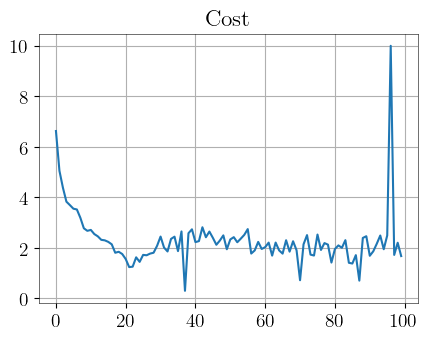

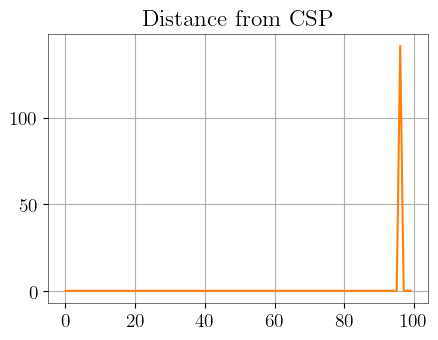

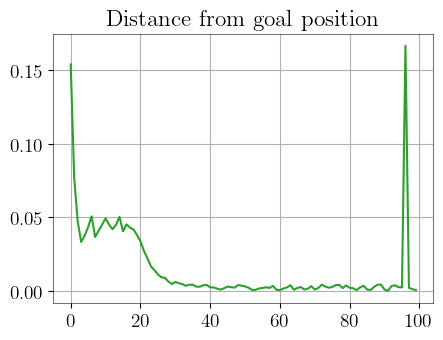

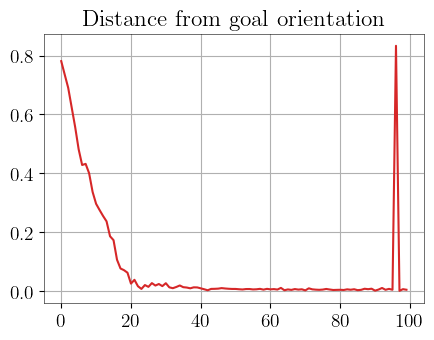

In [83]:
result_0_stab = "results_short_traj_upper_body_goal_dtw_56_lr03_pos/"
df = plot_costs(result_0_stab, plot=True)

In [75]:
plot_cop(result_0_stab)

FileNotFoundError: results_short_traj_upper_body_goal_dtw_56_lr03_pos/update00149/eval_cost_vars.txt not found.

In [76]:
plot_ee_traj(result_0_stab)

FileNotFoundError: results_short_traj_upper_body_goal_dtw_56_lr03_pos//update00149/eval_cost_vars.txt not found.

In [55]:
df["stab_cost"].loc[df["stab_cost"]>0.5]

137    0.659001
Name: stab_cost, dtype: float64

In [56]:
cost_vars = np.loadtxt(result_0_stab+"update00137/eval_cost_vars.txt")
cost_vars

array([[ 5.99735538e-01,  2.99169036e-01, -5.00409774e-01, ...,
         4.84545795e-02, -7.87360075e-02,  2.89173251e-03],
       [ 5.99600925e-01,  2.98813455e-01, -4.98689516e-01, ...,
         4.84545795e-02, -7.87360075e-02,  2.89173251e-03],
       [ 6.00746927e-01,  2.96057704e-01, -4.95798060e-01, ...,
         4.84536409e-02, -7.87373529e-02,  2.88805508e-03],
       ...,
       [ 2.90805819e-01,  8.48211962e-01, -6.56898771e-01, ...,
         4.79045271e-02, -7.96707394e-02,  3.69457263e-03],
       [ 2.90805819e-01,  8.48211962e-01, -6.56898771e-01, ...,
         4.79072625e-02, -7.96736094e-02,  3.70962357e-03],
       [ 1.00000000e+02,  1.00000000e+02,  1.00000000e+02, ...,
         1.00000000e+02,  1.00000000e+02,  1.00000000e+02]])

In [57]:
calculate_dist_to_cop(cost_vars[:-1,:])

0.09384557831408881

In [58]:
calculate_dist_to_cop(cost_vars)

0.659001366660598

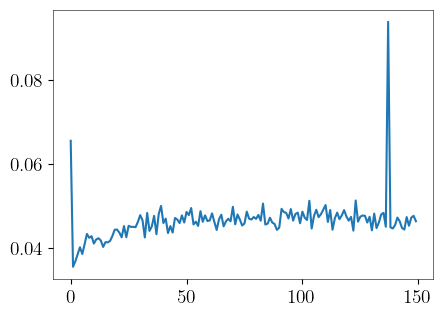

In [59]:
df["stab_cost"].iloc[137] = calculate_dist_to_cop(cost_vars[:-1,:])
plt.plot(df["stab_cost"])

In [13]:
# with w_stab=0 as first evaluation
results_spo = ["results_short_traj_upper_body_goal_dtw_53_lr03_pos/",
               "results_short_traj_upper_body_goal_dtw_55_lr03_pos/",
               "results_short_traj_upper_body_goal_dtw_29_lr03/",
               "results_short_traj_upper_body_goal_dtw_40_lr03_pos/"]

# results_spo = ["results_short_traj_upper_body_goal_dtw_53_lr03_pos/",
#                "results_short_traj_upper_body_goal_dtw_22_lr03/",
#                "results_short_traj_upper_body_goal_dtw_29_lr03/",
#                "results_short_traj_upper_body_goal_dtw_40_lr03_pos/"]

# non zero w_stab
# results_spo = ["results_short_traj_upper_body_goal_dtw_22_lr03/",
#                "results_short_traj_upper_body_goal_dtw_28_lr03/",
#                "results_short_traj_upper_body_goal_dtw_29_lr03/",
#                "results_short_traj_upper_body_goal_dtw_40_lr03_pos/"]

# results_spo = ["results_short_traj_upper_body_goal_dtw_28_lr03/",
#                "results_short_traj_upper_body_goal_dtw_29_lr03/",
#                "results_short_traj_upper_body_goal_dtw_40_lr03_pos/"]



In [31]:
w = [r"$w_{stab} = $" + "0", r"$w_{stab} = $" + "10", r"$w_{stab} = $" + "15", r"$w_{stab} = $" + "20"]
# w = [r"$w_{stab} = $" + "10", r"$w_{stab} = $" + "15", r"$w_{stab} = $" + "20"]

reaching_errors(results_spo, w)

yes


$w_{stab} = $0 $w_{stab} = $10 $w_{stab} = $15   
Positional error                0.000726        0.001329        0.000333  \
Positional RMSE                 0.003099        0.004233        0.007844   
Positional min                  0.000349        0.001247        0.000333   
Orientational error             0.003677        0.002673        0.004922   
Orientational RMSE              0.005897        0.005757        0.010266   
Orientational min               0.001455        0.001127        0.001502   
Average distance from CSP       0.046923        0.044695        0.036436   
Min distance from CSP           0.044048        0.040821         0.03084   
Average DTW distance            2.414478        1.829965        2.252756   
Min DTW distance                2.351173        1.757251        2.228006   
Average acc cost                1.433709        1.356619        1.565905   
Min acc cost                    1.400495        1.351771        1.547938   

                          $w_{stab} = $20  
Positional error                 0.001188  
Positional RMSE                  0.002004  
Positional min                   0.000282  
Orientational error              0.006131  
Orientational RMSE               0.004654  
Orientational min                0.000795  
Average distance from CSP        0.035174  
Min distance from CSP            0.031025  
Average DTW distance             1.920242  
Min DTW distance                 1.858466  
Average acc cost                 1.434049  
Min acc cost                     1.421544

yes


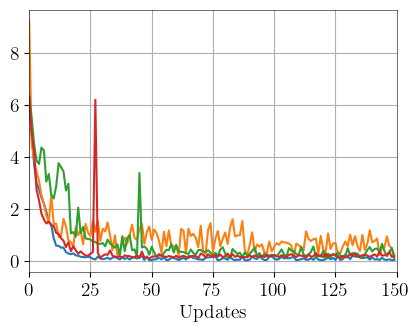

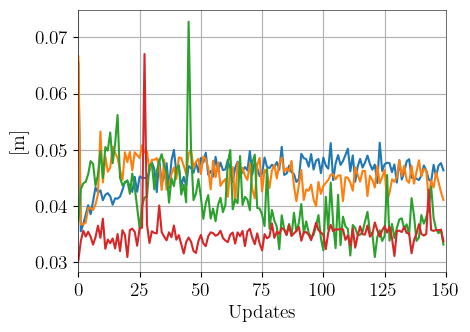

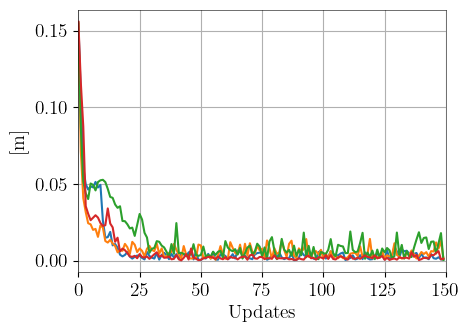

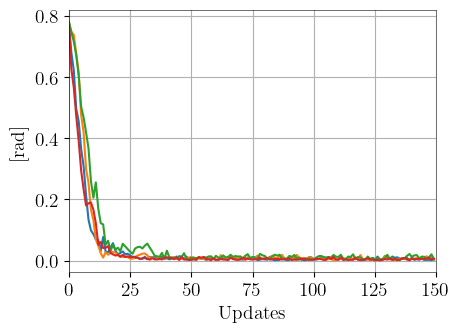

In [20]:
w = [r"$w_{stab}=0$", r"$w_{stab}=5$", r"$w_{stab}=15$", r"$w_{stab}=20$"]
compare_costs(results_spo, w, "plots_stab_goal_orient", save=True)

In [64]:
len(df)/30

5.0

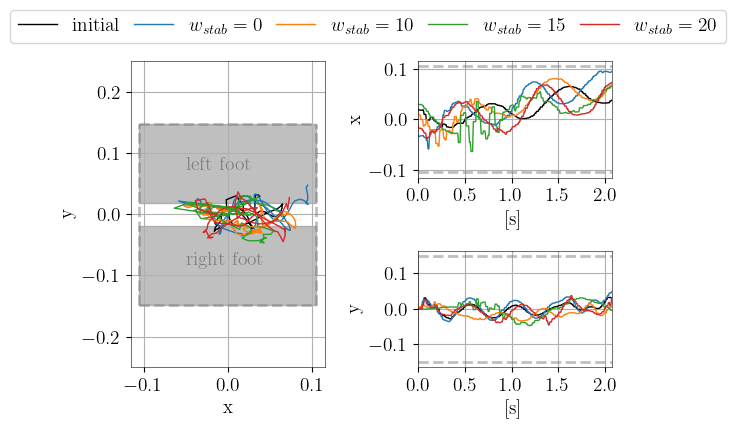

In [75]:
w = [r"$w_{stab}=0$", r"$w_{stab}=10$", r"$w_{stab}=15$", r"$w_{stab}=20$"]
compare_zmps(results_spo, w, "plots_stab_goal_orient")

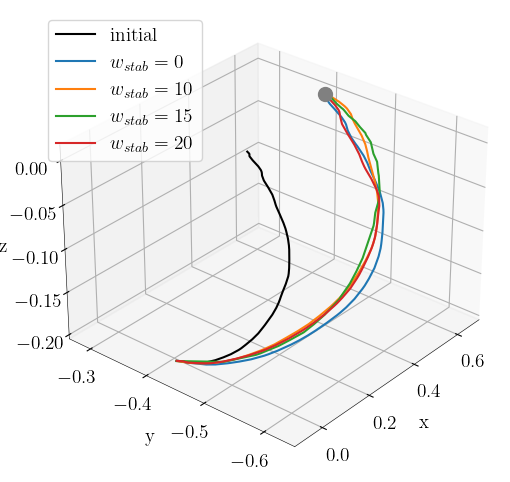

In [87]:
w = [r"$w_{stab}=0$", r"$w_{stab}=10$", r"$w_{stab}=15$", r"$w_{stab}=20$"]

# w = [r"$w_{stab} = 10$", r"$w_{stab} = 15$", r"$w_{stab} = 20$"]
compare_ee_trajs(results_spo, w, "plots_stab_goal_orient")

-----------------------------------------------------------

# STABILITY, POSITION, ORIENTATION, TRAJECTORY


# Overall cost function 
### *Trajectory similarity term added in the cost function*

$J(\boldsymbol{\tau}) = w_{stab}J(\boldsymbol{\tau})_{stab} + w_{Pgoal}J(\boldsymbol{\tau})_{Pgoal} + w_{Rgoal}J(\boldsymbol{\tau})_{traj} + w_{traj}J(\boldsymbol{\tau})_{traj}$

### Stability cost

$J(\boldsymbol{\tau})_{stab} = \frac{1}{N+1}\sum_{i=0}^N f_{stab}(\boldsymbol{x}_{ZMP}(t_i))$

### Position goal cost 

$J(\boldsymbol{\tau})_{Pgoal} =  ||\boldsymbol{x}_{ee}(T) - \boldsymbol{g})||^2$

### Orientation goal cost 

$J(\boldsymbol{\tau})_{Rgoal} =  2 || \log\left(\boldsymbol{q}(T) \ast \boldsymbol{\tilde{q}}_g\right)||$

### Trajectory cost

$J(\boldsymbol{\tau})_{traj} =  \frac{1}{N}\sum_{i=0}^N  DTW(\boldsymbol{\tau},\boldsymbol{\tau}_{demonstrated})$

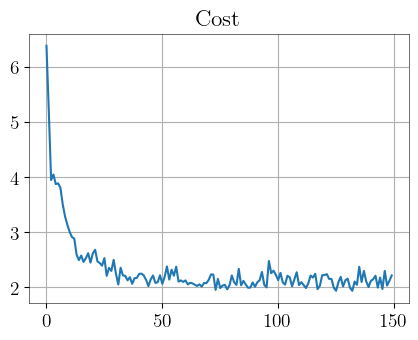

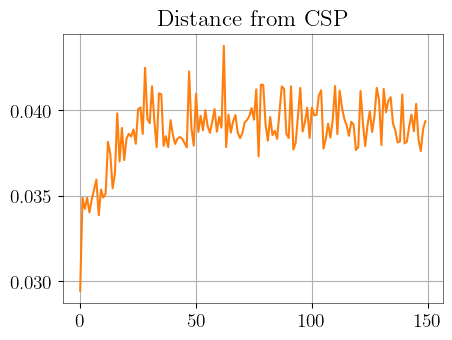

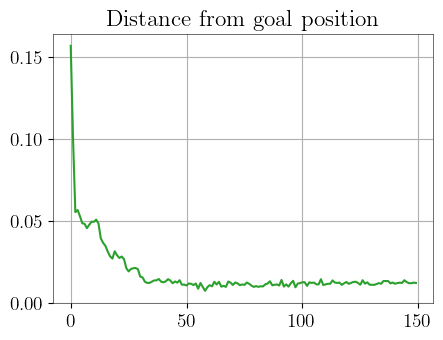

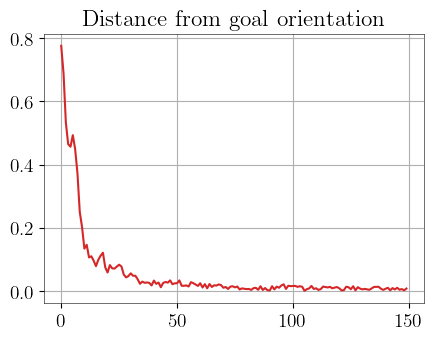

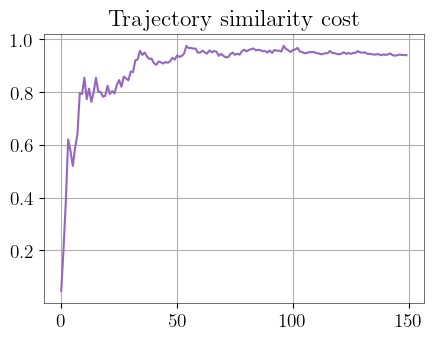

In [107]:
res_traj_1_5 = "results_short_traj_upper_body_goal_dtw_57_lr03_pos/"
df = plot_costs(res_traj_1_5, plot=True)

In [105]:
df["goal_cost"].iloc[-1]/20

0.01282704020052503

In [22]:
# results_spot = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_32_lr03/",
#                 "results_short_traj_upper_body_goal_dtw_41_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_46_lr03_pos/"]

# w_traj = [0.0, 0.3, 0.5, 10]
# results_spot = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_32_lr03/",
#                 "results_short_traj_upper_body_goal_dtw_48_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_46_lr03_pos/"]

# w_traj = [0.0, 0.5, 5, 10]
# results_spot = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_48_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_54_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_46_lr03_pos/"]

# w_traj = [0.0, 0.3, 0.5, 5]
# results_spot = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_32_lr03/",
#                 "results_short_traj_upper_body_goal_dtw_48_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_54_lr03_pos/"]

# w_traj = [0.0, 0.5, 1.5, 5]
results_spot = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
                "results_short_traj_upper_body_goal_dtw_48_lr03_pos/",
                "results_short_traj_upper_body_goal_dtw_57_lr03_pos/",
                "results_short_traj_upper_body_goal_dtw_54_lr03_pos/"]

# results_spot = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
#                 "results_short_traj_upper_body_goal_dtw_32_lr03/",
#                 "results_short_traj_upper_body_goal_dtw_31_lr03/"]

In [122]:
w = [r"$w_{traj} =$" + "0.0", r"$w_{traj} =$" + "0.5", r"$w_{traj} =$" + "1.5", r"$w_{traj} =$" + "5"]
# w = [r"$w_{traj} =$" + "0.0", r"$w_{traj} =$" + "0.3", r"$w_{traj} =$" + "0.5"]

reaching_errors(results_spot, w)

yes


$w_{traj} =$0.0 $w_{traj} =$0.5 $w_{traj} =$1.5   
Positional error                 0.001188        0.007117        0.012023  \
Positional RMSE                  0.002004        0.005289        0.012036   
Positional min                   0.000282        0.003525        0.010244   
Orientational error              0.006131         0.00953        0.007664   
Orientational RMSE               0.004654        0.005487        0.008558   
Orientational min                0.000795        0.000345        0.000451   
Average distance from CSP        0.035174        0.038969        0.039382   
Min distance from CSP            0.031025         0.03687        0.037614   
Average DTW distance             1.920242        1.295563        0.946498   
Min DTW distance                 1.858466        1.284717        0.937545   
Average acc cost                 1.434049        1.362119        1.420535   
Min acc cost                     1.421544        1.354456        1.413231   

                          $w_{traj} =$5  
Positional error               0.023834  
Positional RMSE                0.023424  
Positional min                 0.022702  
Orientational error            0.497455  
Orientational RMSE             0.494579  
Orientational min              0.486843  
Average distance from CSP       0.03627  
Min distance from CSP          0.033431  
Average DTW distance           0.267228  
Min DTW distance                0.26535  
Average acc cost                0.95692  
Min acc cost                   0.954302

yes


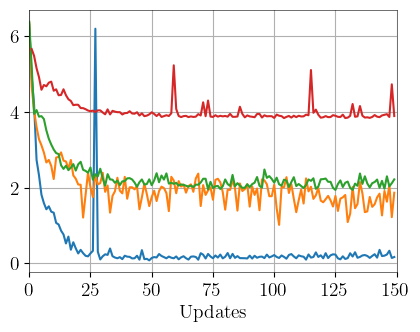

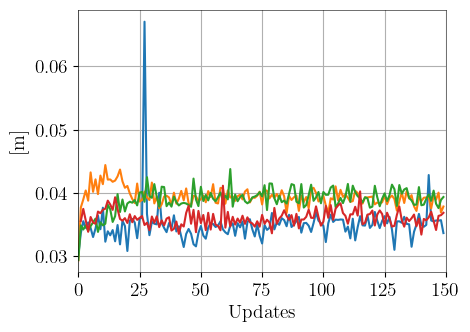

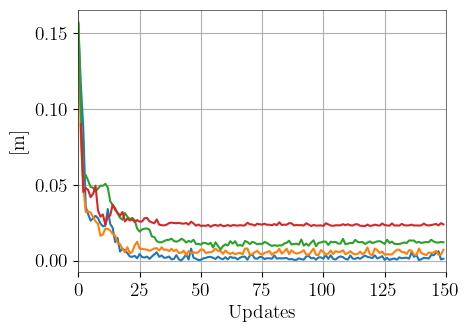

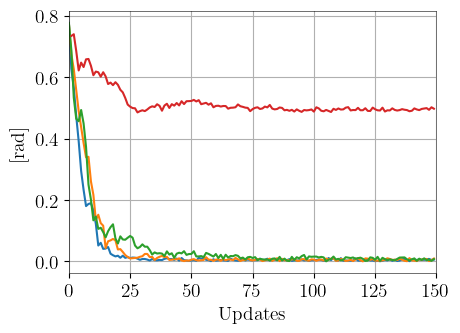

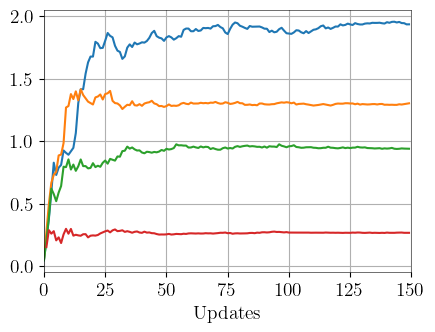

In [23]:
w = [r"$w_{traj}=0.0$", r"$w_{traj}=0.5$", r"$w_{traj}=1.5$", r"$w_{traj}=5$"]
# w = [r"$w_{traj} = 0.0$", r"$w_{traj} = 0.3$", r"$w_{traj} = 0.5$", r"$w_{traj} = 0.7$"]

compare_costs(results_spot, w, "plots_stab_goal_orient_traj", save=True)

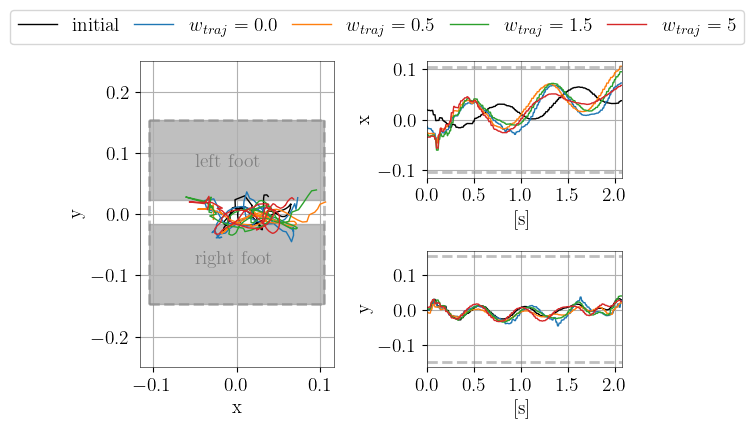

In [76]:
w = [r"$w_{traj}=0.0$", r"$w_{traj}=0.5$", r"$w_{traj}=1.5$", r"$w_{traj}=5$"]
# w = [r"$w_{traj} = 0.0$", r"$w_{traj} = 0.3$", r"$w_{traj} = 0.5$", r"$w_{traj} = 0.7$"]

compare_zmps(results_spot, w, "plots_stab_goal_orient_traj")

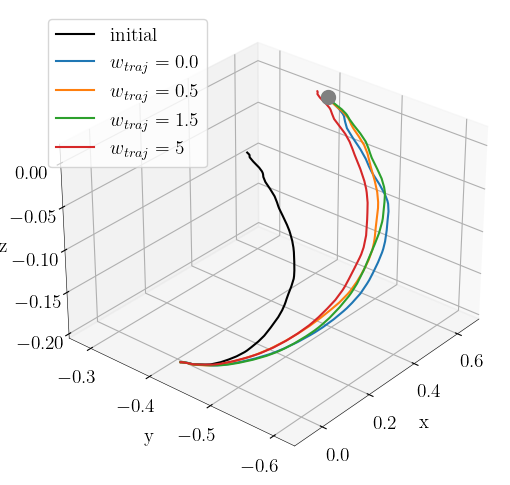

In [121]:
w = [r"$w_{traj}=0.0$", r"$w_{traj}=0.5$", r"$w_{traj}=1.5$", r"$w_{traj}=5$"]
# w = [r"$w_{traj} = 0.0$", r"$w_{traj} = 0.3$", r"$w_{traj} = 0.5$", r"$w_{traj} = 0.7$"]

compare_ee_trajs(results_spot, w, "plots_stab_goal_orient_traj")

In [ ]:
# w = [r"$w_{traj} =$" + "0.0", r"$w_{traj} =$" + "0.3", r"$w_{traj} =$" + "0.5", r"$w_{traj} =$" + "0.7"]
# plot_ee_trajectories(results_spot, w)

-------------------------------------------------------------

# STABILITY, POSITION, ORIENTATION, TRAJECTORY, ACCELERATION


# Overall cost function 
### *Acceleration cost added in the cost function*

$J(\boldsymbol{\tau}) = w_{stab}J(\boldsymbol{\tau})_{stab} + w_{Pgoal}J(\boldsymbol{\tau})_{Pgoal} + w_{Rgoal}J(\boldsymbol{\tau})_{traj} + w_{traj}J(\boldsymbol{\tau})_{traj} + w_{acc}J(\boldsymbol{\tau})_{acc}$

### Stability cost

$J(\boldsymbol{\tau})_{stab} = \frac{1}{N+1}\sum_{i=0}^N f_{stab}(\boldsymbol{x}_{ZMP}(t_i))$

### Position goal cost 

$J(\boldsymbol{\tau})_{Pgoal} =  ||\boldsymbol{x}_{ee}(T) - \boldsymbol{g})||^2$

### Orientation goal cost 

$J(\boldsymbol{\tau})_{Rgoal} =  2 || \log\left(\boldsymbol{q}(T) \ast \boldsymbol{\tilde{q}}_g\right)||$

### Trajectory cost

$J(\boldsymbol{\tau})_{traj} =  \frac{1}{N}\sum_{i=0}^N  DTW(\boldsymbol{\tau},\boldsymbol{\tau}_{demonstrated})$

### Acceleration cost

$J(\boldsymbol{\tau})_{acc} = \frac{1}{N}\sum_{i=0}^N ||\boldsymbol{\ddot{\tau}}(t_i)||^2$

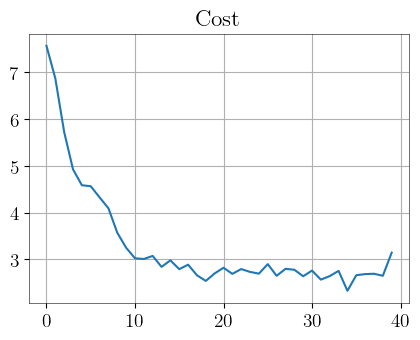

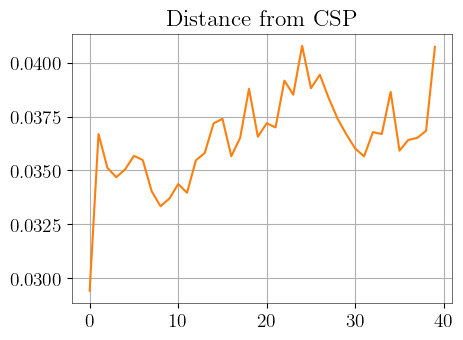

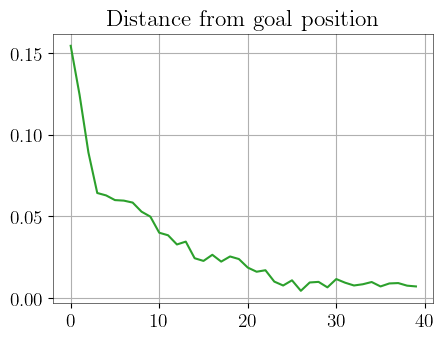

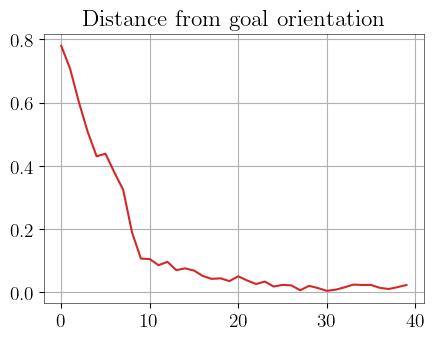

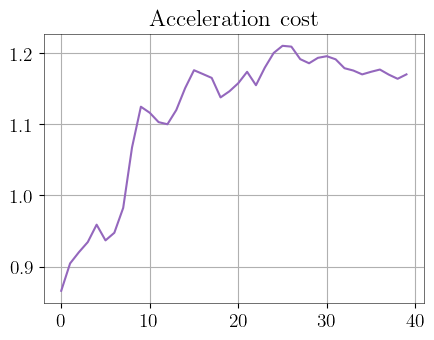

cost  stab_cost  goal_cost  orient_cost  acc_cost
0   7.566607   0.029405   3.091192     3.118676  1.298889
1   6.870299   0.036691   2.491048     2.829712  1.356552
2   5.723686   0.035123   1.783841     2.404285  1.380315
3   4.925629   0.034686   1.286266     2.027372  1.401547
4   4.586620   0.035047   1.256593     1.721031  1.438257
5   4.565395   0.035678   1.199171     1.753711  1.405121
6   4.326852   0.035482   1.192754     1.517472  1.421178
7   4.094129   0.034036   1.168589     1.296493  1.473523
8   3.571277   0.033335   1.057343     0.758103  1.601106
9   3.250208   0.033688   0.996285     0.427183  1.686817
10  3.025429   0.034368   0.799133     0.420599  1.674065
11  3.010078   0.033961   0.767766     0.343265  1.654342
12  3.075444   0.035468   0.655007     0.385770  1.649874
13  2.841662   0.035814   0.690008     0.281073  1.679885
14  2.981210   0.037190   0.486377     0.303700  1.726048
15  2.792485   0.037396   0.453376     0.275556  1.763742
16  2.888180   0.035659   0.528455     0.206837  1.755722
17  2.662225   0.036515   0.444933     0.170379  1.747550
18  2.541590   0.038795   0.507886     0.177324  1.706431
19  2.701713   0.036568   0.476365     0.142182  1.719295
20  2.822865   0.037191   0.371854     0.202982  1.736350
21  2.692922   0.036998   0.320818     0.150240  1.760369
22  2.794729   0.039173   0.339039     0.105677  1.732136
23  2.733622   0.038520   0.199684     0.136152  1.769188
24  2.697026   0.040792   0.151918     0.073459  1.800110
25  2.900385   0.038821   0.215520     0.094316  1.815175
26  2.650780   0.039448   0.086805     0.087484  1.813435
27  2.798831   0.038367   0.188987     0.026737  1.787085
28  2.780539   0.037410   0.196306     0.082420  1.778389
29  2.641339   0.036673   0.129098     0.054018  1.789839
30  2.761954   0.036015   0.230816     0.019379  1.793273
31  2.568959   0.035653   0.186259     0.033290  1.786714
32  2.644699   0.036782   0.152108     0.063167  1.767952
33  2.756267   0.036692   0.167194     0.097907  1.763066
34  2.329997   0.038650   0.194546     0.092852  1.754946
35  2.663377   0.035918   0.140418     0.093276  1.760401
36  2.686768   0.036417   0.177194     0.056918  1.765156
37  2.694542   0.036512   0.181682     0.041817  1.754510
38  2.651250   0.036837   0.149925     0.066059  1.745663
39  3.145929   0.040736   0.140527     0.092539  1.754971

In [125]:
res_acc_1_0 = "results_short_traj_upper_body_goal_dtw_59_lr03_pos/"
plot_costs(res_acc_1_0, plot=True)

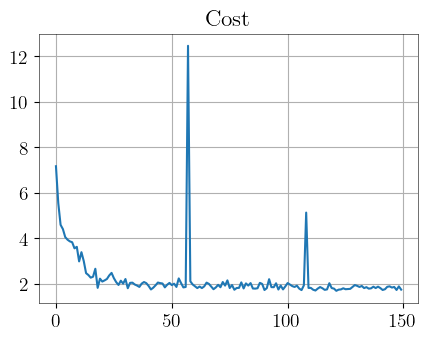

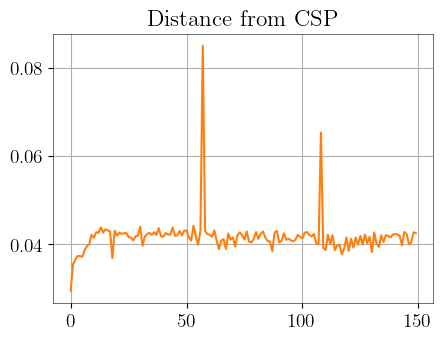

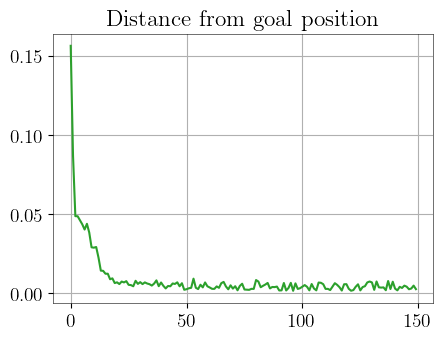

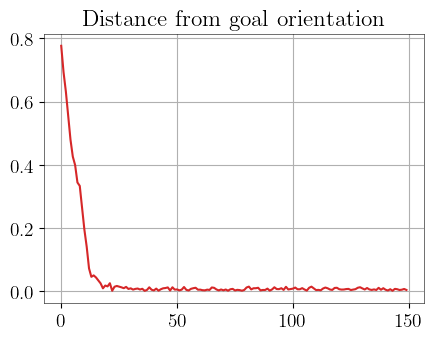

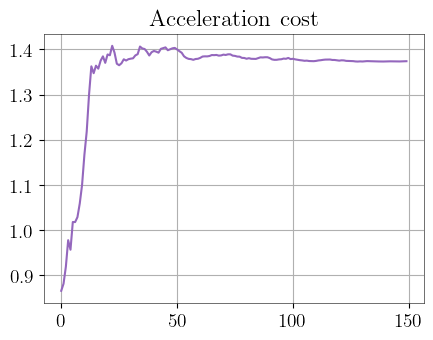

cost  stab_cost  goal_cost  orient_cost  acc_cost
0    7.165682   0.029376   3.126040     3.105947  0.865926
1    5.545157   0.035429   1.738994     2.773502  0.881609
2    4.587653   0.036483   0.973267     2.528333  0.919192
3    4.399835   0.037302   0.972013     2.222855  0.977923
4    4.049977   0.037265   0.920037     1.919511  0.956877
..        ...        ...        ...          ...       ...
145  1.828445   0.042226   0.081913     0.028911  1.373686
146  1.855402   0.039898   0.049293     0.018967  1.373496
147  1.722870   0.040430   0.058817     0.022651  1.373694
148  1.880113   0.042660   0.095097     0.031977  1.373840
149  1.736650   0.042439   0.050833     0.019394  1.374052

[150 rows x 5 columns]

In [126]:
res_acc_1_0 = "results_short_traj_upper_body_goal_dtw_58_lr03_pos/"
plot_costs(res_acc_1_0, plot=True)

In [24]:
# results_spota = ["results_short_traj_upper_body_goal_dtw_31_lr03/",
#                  "results_short_traj_upper_body_goal_dtw_37_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_38_lr03_pos/"]

# w_traj = 0.0
results_spota = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_58_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_59_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_60_lr03_pos/"]

# # w_traj = 0.5
# results_spota = ["results_short_traj_upper_body_goal_dtw_48_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_37_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_38_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_45_lr03_pos/"]

# w_traj = 0.3
# results_spota = ["results_short_traj_upper_body_goal_dtw_32_lr03/",
#                  "results_short_traj_upper_body_goal_dtw_42_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_43_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_44_lr03_pos/"]

# w_traj = 0.7
# results_spota = ["results_short_traj_upper_body_goal_dtw_41_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_49_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_50_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_51_lr03_pos/"]


# results_spota = ["results_short_traj_upper_body_goal_dtw_32_lr03/",
#                  "results_short_traj_upper_body_goal_dtw_42_lr03_pos/",
# #                  "results_short_traj_upper_body_goal_dtw_43_lr03_pos/",
#                  "results_short_traj_upper_body_goal_dtw_45_lr03_pos/"]

In [21]:
w = [r"$w_{acc} =$" + "0.0", r"$w_{acc} =$" + "1.0", r"$w_{acc} =$" + "1.5", r"$w_{acc} =$" + "10"]
# w = [r"$w_{acc} =$" + "0.0", r"$w_{acc} =$" + "0.5", r"$w_{acc} =$" + "1.0"]

reaching_errors(results_spota, w)

$w_{acc} =$0.0 $w_{acc} =$1.0 $w_{acc} =$1.5   
Positional error                0.001188       0.002542        0.00746  \
Positional RMSE                 0.002004       0.004085       0.004708   
Positional min                  0.000282        0.00154       0.000528   
Orientational error             0.006131       0.004848       0.016419   
Orientational RMSE              0.004654       0.007702       0.010903   
Orientational min               0.000795       0.002391       0.002134   
Average distance from CSP       0.035174       0.041365       0.036537   
Min distance from CSP           0.031025       0.037682       0.034672   
Average DTW distance            1.920242       1.453939       1.806921   
Min DTW distance                1.858466       1.438822       1.785037   
Average acc cost                1.434049       1.374912       1.181379   
Min acc cost                    1.421544       1.373275       1.177898   

                          $w_{acc} =$10  
Positional error                 0.0402  
Positional RMSE                0.041416  
Positional min                   0.0402  
Orientational error            0.117943  
Orientational RMSE             0.119535  
Orientational min              0.111367  
Average distance from CSP      0.037161  
Min distance from CSP          0.035272  
Average DTW distance           0.999886  
Min DTW distance               0.990855  
Average acc cost                0.88617  
Min acc cost                   0.885135

In [72]:
5e-3

0.005

In [29]:
cost_vars_31 = np.loadtxt("results_short_traj_upper_body_goal_dtw_28_lr03/update00000/eval_cost_vars.txt")
cost_vars_40 = np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars.txt")

In [30]:
n_misc=15
cop_y_31 = copy.copy(cost_vars_31[:,-n_misc+1])
cop_x_31 = copy.copy(cost_vars_31[:,-n_misc])

cop_y_40 = copy.copy(cost_vars_40[:,-n_misc+1])
cop_x_40 = copy.copy(cost_vars_40[:,-n_misc])

In [ ]:
plt.figure()
plt.plot(cop_x_31)
plt.plot(cop_x_40)
plt.show()

plt.figure()
plt.plot(cop_y_31)
plt.plot(cop_y_40)
plt.show()

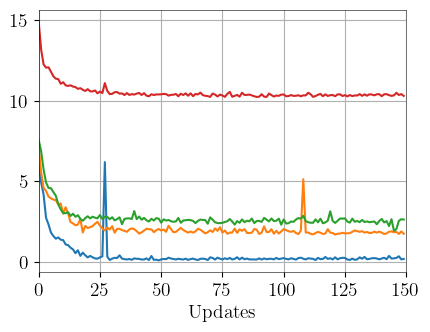

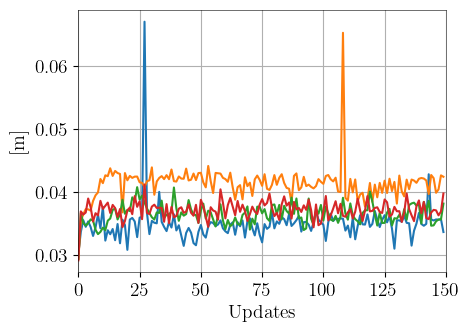

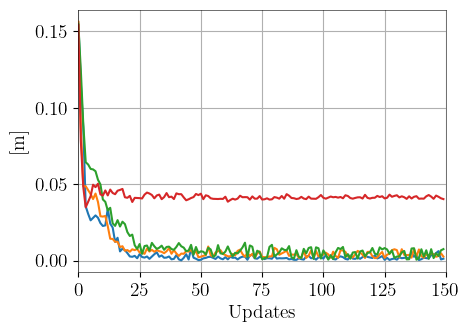

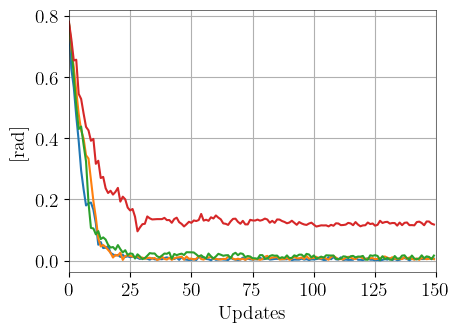

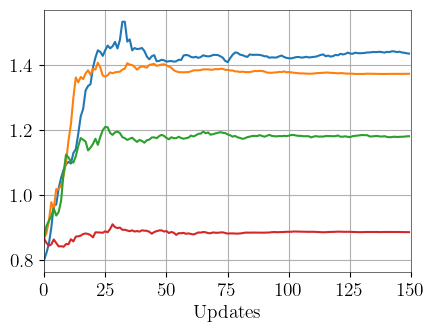

In [25]:
w = [r"$w_{acc} = 0.0$", r"$w_{acc} = 1.0$", r"$w_{acc} = 1.5$", r"$w_{acc} = 10$"]
compare_costs(results_spota, w, "plots_stab_goal_orient_traj_acc", save=True)

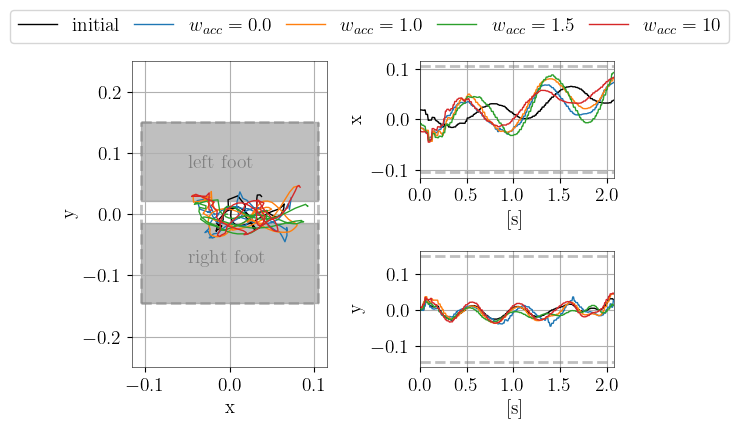

In [77]:
w = [r"$w_{acc} = 0.0$", r"$w_{acc} = 1.0$", r"$w_{acc} = 1.5$", r"$w_{acc} = 10$"]
compare_zmps(results_spota, w, "plots_stab_goal_orient_traj_acc")

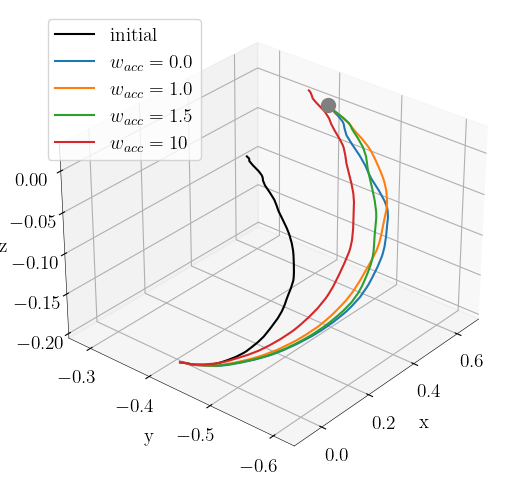

In [29]:
w = [r"$w_{acc} = 0.0$", r"$w_{acc} = 1.0$", r"$w_{acc} = 1.5$", r"$w_{acc} = 10$"]
compare_ee_trajs(results_spota, w, "plots_stab_goal_orient_traj_acc")

------------------------------------------------

# Other comparisons

In [86]:
results_ = ["results_short_traj_upper_body_goal_dtw_49_lr03_pos/",
            "results_short_traj_upper_body_goal_dtw_50_lr03_pos/",
            "results_short_traj_upper_body_goal_dtw_52_lr03_pos/"]

In [61]:
results_ = ["results_short_traj_upper_body_goal_dtw_2_lr03_pos/",
            "results_short_traj_upper_body_goal_dtw_22_lr03/"]

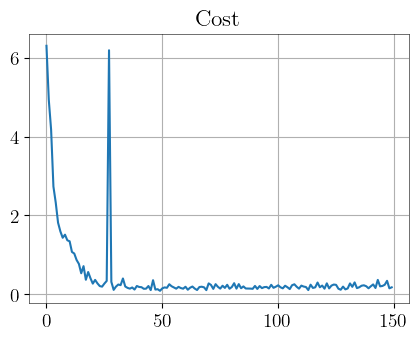

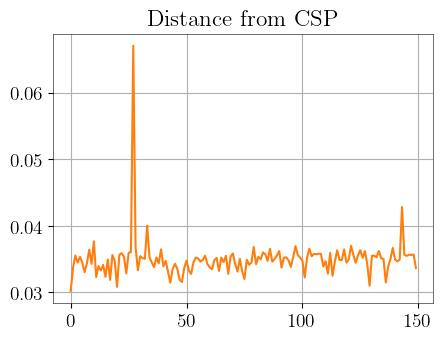

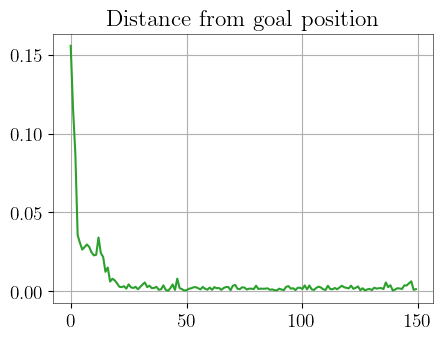

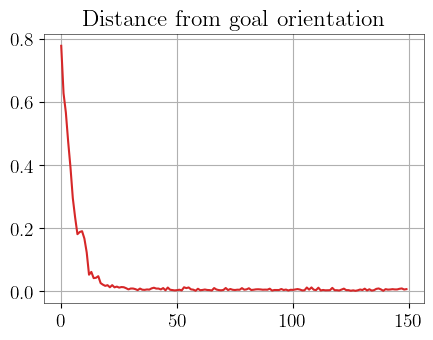

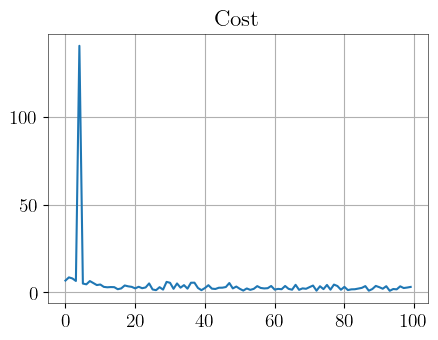

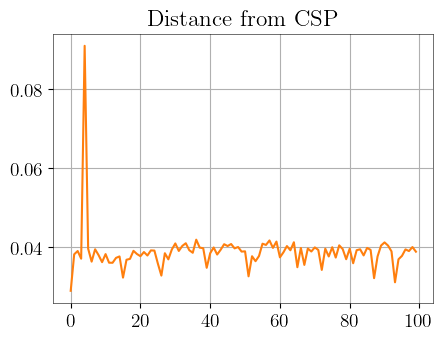

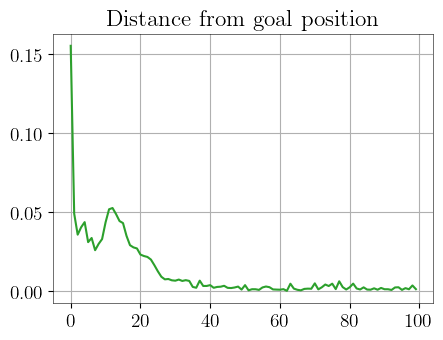

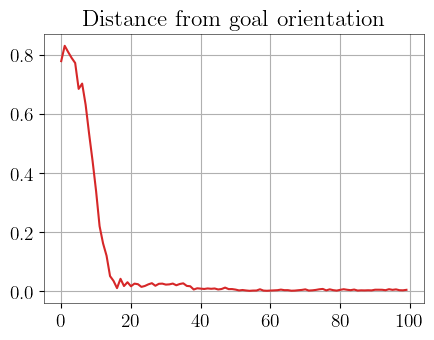

In [94]:
df_20 = plot_costs("results_short_traj_upper_body_goal_dtw_40_lr03_pos/", plot=True)
df_1 = plot_costs("results_short_traj_upper_body_goal_dtw_62_lr03_pos/", plot=True)
# df_1.iloc[96] = np.nan

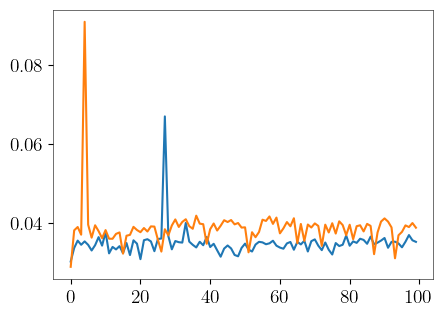

In [95]:
plt.plot(df_20["stab_cost"].iloc[:100])
plt.plot(df_1["stab_cost"])
plt.show()

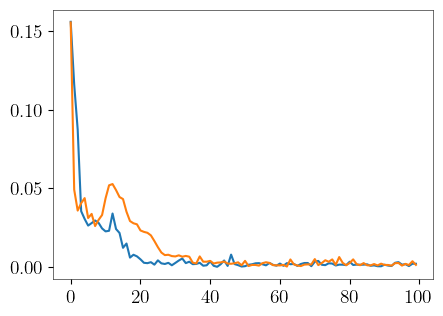

In [96]:
plt.plot(df_20["goal_cost"].iloc[:100]/20)
plt.plot(df_1["goal_cost"]/20)
plt.show()

In [97]:
df_1["goal_cost"].iloc[-1]/20

0.0013155177341934257

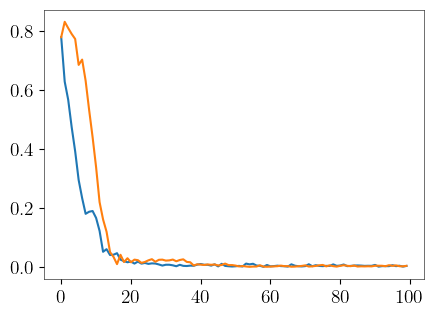

In [99]:
plt.plot(df_20["orient_cost"].iloc[:100]/4)
plt.plot(df_1["orient_cost"]/4)
plt.show()


In [62]:
w = ["20 and 4", "5 and 1"]
compare_costs(results_, w, "test_plot", save=False)

FileNotFoundError: results_short_traj_upper_body_goal_dtw_2_lr03_pos//update00100/eval_cost_vars.txt not found.

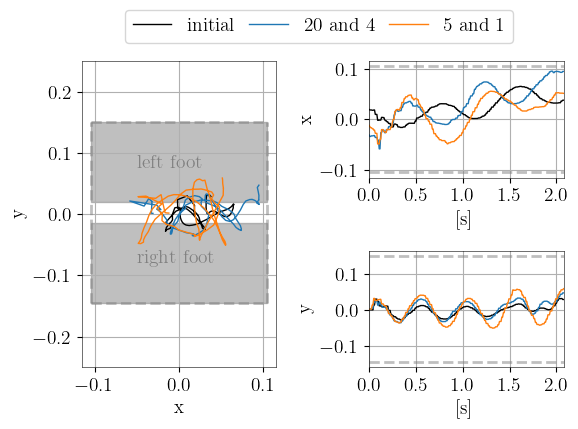

In [52]:
w = ["20 and 4", "5 and 1"]
compare_zmps(results_, w, "", save=False)

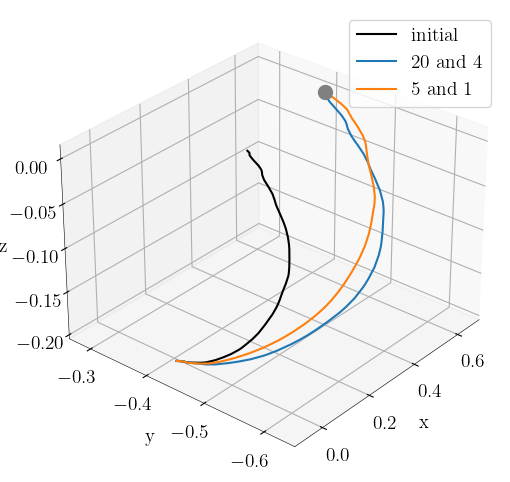

In [53]:
w = ["20 and 4", "5 and 1"]
compare_ee_trajs(results_, w, "", save=False)

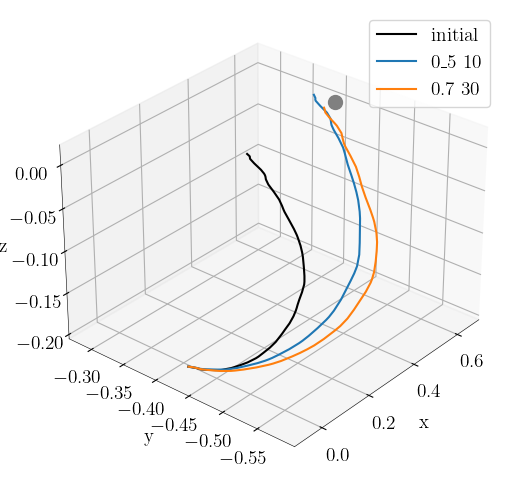

In [21]:
results_10_30 = ["results_short_traj_upper_body_goal_dtw_45_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_52_lr03_pos/"]

w = ["0_5 10", "0.7 30"]
compare_ee_trajs(results_10_30, w, "", save=False)

In [115]:
results_stability = ["results_short_traj_upper_body_goal_dtw_53_lr03_pos/",
                     "results_short_traj_upper_body_goal_dtw_22_lr03/",
                     "results_short_traj_upper_body_goal_dtw_55_lr03_pos/",
                     "results_short_traj_upper_body_goal_dtw_29_lr03/",
                     "results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
                     "results_short_traj_upper_body_goal_dtw_56_lr03_pos/",
                     "results_short_traj_upper_body_goal_dtw_62_lr03_pos/"]

weights = [1, 5, 10, 15, 20, 100, 200]

In [141]:
def calculate_costs(result):
    updates = np.sort([upd for upd in os.listdir(result) if "update0" in upd])
    costs = []
    for update in updates:
        if "update0" in update and update!="update00100" and update!="update00150":
            files = os.listdir(os.path.join(os.getcwd(), result + update))
            for f in files:
                if "eval_costs.txt" in f:
                    c = np.loadtxt(os.path.join(os.getcwd(), result + update) + "/" + f)
                    costs.append(c)
    res = pd.DataFrame(columns=["cost", "stab_cost", "goal_cost", "orient_cost"], data=costs)
    return res

def calculate_avg_cost(costs, stab_weight):
    avg_cost = (costs["stab_cost"].iloc[-70:]/stab_weight).mean() + \
               (costs["goal_cost"].iloc[-70:]/20.0).mean() + \
               (costs["orient_cost"].iloc[-70:]/4.0).mean()
    return avg_cost

In [142]:
avg = [0]*len(weights)
for i, result in enumerate(results_stability):
    costs = calculate_costs(result)
    avg[i] = calculate_avg_cost(costs, weights[i])

In [143]:
avg

[0.07053476124919739,
 0.041441237091969924,
 0.06660592260864105,
 0.02415210053523069,
 0.013165223818809545,
 0.04350607240847797,
 0.022315246961199242]

In [145]:
np.sign(-5)

-1

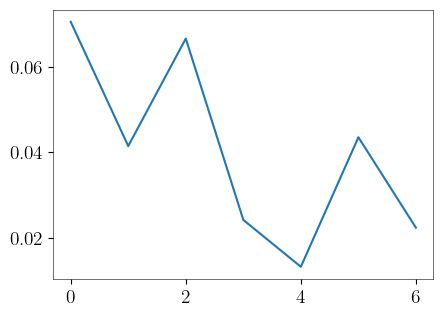

In [144]:
plt.plot(avg)

In [4]:
results_28 = "results_short_traj_upper_body_goal_dtw_28_lr03/"
results_29 = "results_short_traj_upper_body_goal_dtw_29_lr03/"
results_31 = "results_short_traj_upper_body_goal_dtw_31_lr03/"


In [ ]:
cost_vars_31 = np.loadtxt(results_31+"update00149/eval_cost_vars.txt")
cost_vars_31_hz = np.loadtxt(results_31+"update00150/eval_cost_vars_test_hz.txt")

dmp_31 = jc.loadjson(results_31+"update00150/eval_dmp.json")

ts_31 = dmp_31.ts_train
xs, xds, forcing, fa_outputs = dmp_31.analytical_solution()
traj_31 = dmp_31.states_as_trajectory(ts_31, xs, xds)

plt.plot(cost_vars_31[:, 21])
plt.plot(cost_vars_31_hz[:, 21])
plt.plot(traj_31.yds[:,3])


In [ ]:
# velocity validation

cost_vars_29 = np.loadtxt(results_29+"update00149/eval_cost_vars.txt")
cost_vars_31 = np.loadtxt(results_31+"update00149/eval_cost_vars.txt")
n_dims = 18
vel_29 = cost_vars_29[:,n_dims:2*n_dims]
vel_31 = cost_vars_31[:,n_dims:2*n_dims]

dmp_29 = jc.loadjson(results_29+"update00149/eval_dmp.json")
dmp_31 = jc.loadjson(results_31+"update00149/eval_dmp.json")

ts_29 = dmp_29.ts_train
xs, xds, forcing, fa_outputs = dmp_29.analytical_solution()
traj_29 = dmp_29.states_as_trajectory(ts_29, xs, xds)

ts_31 = dmp_31.ts_train
xs, xds, forcing, fa_outputs = dmp_31.analytical_solution()
traj_31 = dmp_31.states_as_trajectory(ts_31, xs, xds)

print("RESULTS 29 \n")
for i in range(n_dims):
    plt.plot(vel_29[:,i])
    plt.plot(traj_29.yds[:,i])
    plt.grid()
    plt.show()
    
print("RESULTS 31 \n")
for i in range(n_dims):
    plt.plot(vel_31[:,i])
    plt.plot(traj_31.yds[:,i])
    plt.grid()
    plt.show()
    

In [ ]:
traj = np.loadtxt("trajectories/trajectory.txt")

plt.plot(traj[:,2])
plt.plot(traj_29.ys[:,1])

In [ ]:
df_28 = plot_costs(results_28, subplots=True)

In [ ]:
df_29 = plot_costs(results_29, subplots=True)

In [ ]:
results_23 = "results_short_traj_upper_body_goal_dtw_23_lr03/"
df_23 = plot_costs("results_short_traj_upper_body_goal_dtw_23_lr03/", subplots=True)

In [ ]:
results_31 = "results_short_traj_upper_body_goal_dtw_31_lr03/"
df_31 = plot_costs("results_short_traj_upper_body_goal_dtw_31_lr03/", subplots=True)

In [ ]:
results_32 = "results_short_traj_upper_body_goal_dtw_32_lr03/"
df_32 = plot_costs("results_short_traj_upper_body_goal_dtw_32_lr03/", subplots=True)

In [ ]:
curve2403 = plot_exploration_curve("results_short_traj_upper_body_goal_dtw_24_lr05/")
curve2303 = plot_exploration_curve("results_short_traj_upper_body_goal_dtw_23_lr03/")

In [ ]:
plt.plot(curve2403[:,1])
plt.plot(curve2303[:,1])

plt.grid()
plt.show()


In [ ]:
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_2/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_3_tau/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_4_tau_traj/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_5_dtw/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_6_dtw/"
# results_folder = "results_learning_wb_goal_covar_adapt_initial_traj_7_dtw/"
results_folder = "results_short_traj_2/"
# plot_cop(results_folder)
# plot_ee_traj(results_folder)
plot_costs(results_folder)



In [ ]:


# plot_costs(results_folder)
# plot_ee_traj(results_folder)

In [ ]:
plot_dmps(results_folder)

In [ ]:
acc_sums = np.array([np.sum(acc_filtered[:,a]**2)/len(acc_filtered[:,a]) for a in range(acc_filtered.shape[1])])
            acc_cost = np.sum(acc_sums)/len(acc_sums)traj = np.loadtxt("results_learning_wb_goal_covar_adapt/updates_rarm/update00000/eval_cost_vars.txt")

In [ ]:
dmp_0 = jc.loadjson(results_folder + "/updates_rarm/update00000/eval_dmp.json")
ts_rarm = dmp_0.ts_train
xs, xds, forcing, fa_outputs, q_traj = dmp_0.analytical_solution()
traj_sample = dmp_0.states_as_trajectory(ts_rarm, xs, xds)

dmp_l = jc.loadjson(results_folder + "/updates_larm/update00000/eval_dmp.json")
ts_larm = dmp_l.ts_train
xs, xds, forcing, fa_outputs, q_traj = dmp_l.analytical_solution()
traj_sample_left = dmp_0.states_as_trajectory(ts_larm, xs, xds)

In [ ]:
# <b> Learning reaching to point task </b>

In [ ]:
# plot dmps as subplots (pos, vel, acc) for position
tr = np.loadtxt("trajectories/trajectory.txt")
traj = Trajectory(ts=tr[:,0], ys=tr[:,1:])
traj

dmp = jc.loadjson("results_short_traj_upper_body_goal_dtw_13/dmp_initial.json")
ts = dmp.ts_train
xs, xds, forcing, fa_outputs = dmp.analytical_solution()
traj_dmp = dmp.states_as_trajectory(ts, xs, xds)

colors = ["tab:blue", "tab:orange", "tab:green", "black", "tab:purple", "tab:gray", "tab:blue"]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5))
for i in range(7):
    ax1.plot(traj.ys[:,i], linestyle="-", linewidth=3, color=colors[0], alpha=0.5)
    ax1.plot(traj_dmp.ys[:,i], linestyle="--", linewidth=1.5, color=colors[0])
    ax1.set_title("Left arm joint angles")
for i in range(7,14):
    ax2.plot(traj.ys[:,i], linestyle="-", linewidth=3, color=colors[0], alpha=0.5)
    ax2.plot(traj_dmp.ys[:,i], linestyle="--", linewidth=1.5, color=colors[0])
    ax2.set_title("Right arm joint angles")
for i in range(14,16):
    ax3.plot(traj.ys[:,i], linestyle="-", linewidth=3, color=colors[0], alpha=0.5)
    ax3.plot(traj_dmp.ys[:,i], linestyle="--", linewidth=1.5, color=colors[0])
    ax3.set_title("Head joint angles")
for i in range(16,18):
    ax4.plot(traj.ys[:,i], linestyle="-", linewidth=3, color=colors[0], alpha=0.5)
    ax4.plot(traj_dmp.ys[:,i], linestyle="--", linewidth=1.5, color=colors[0])
    ax4.set_title("Torso joint angles")    

fig.suptitle("Demonstrated trajectories vs DMP encoded trajectories", weight="bold", fontsize=22)
ax1.legend(["demonstrated", "dmp reproduced"], loc="lower right")
ax2.legend(["demonstrated", "dmp reproduced"])
ax3.legend(["demonstrated", "dmp reproduced"])
ax4.legend(["demonstrated", "dmp reproduced"])

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax3.set_ylim([-0.5, 0.5])

plt.show()

# plot orientation dmp as subplots (pos, vel) for orientation

In [ ]:
# Overall cost function

$J(\boldsymbol{\tau}) = w_{stab}J(\boldsymbol{\tau})_{stab} + w_{Pgoal}J(\boldsymbol{\tau})_{Pgoal} + w_{Rgoal}J(\boldsymbol{\tau})_{Rgoal} + w_{traj}J(\boldsymbol{\tau})_{traj} + w_{acc}J(\boldsymbol{\tau})_{acc} + w_{vel}J(\boldsymbol{\tau})_{vel}$

In [ ]:
## Trajectory cost

$J(\boldsymbol{\tau})_{traj} =  \frac{1}{N}\sum_{i=0}^N  DTW(\boldsymbol{\tau},\boldsymbol{\tau}_{demonstrated})$

In [ ]:
## Acceleration cost

$J(\boldsymbol{\tau})_{acc} = \frac{1}{N}\sum_{i=0}^N ||\boldsymbol{\ddot{\tau}}(t_i)||^2$

In [ ]:
## Velocity cost

$J(\boldsymbol{\tau})_{vel} = ||\boldsymbol{\dot{\tau}}(T)||^2$

In [22]:
# results_folder_no_goal_deviation = "results_short_traj_upper_body_no_goal_deviation/"
# results_folder_no_goal_dtw =       "results_short_traj_upper_body_no_goal_dtw_13/"
# results_folder_goal_deviation =    "results_short_traj_upper_body_goal_deviation/"
# results_folder_goal_dtw =          "results_short_traj_upper_body_goal_dtw_13/"


results_folder_lr05_fail = "results_short_traj_upper_body_goal_dtw_21/"
results_folder_lr05 = "results_short_traj_upper_body_goal_dtw_22/"
results_folder_lr03 = "results_short_traj_upper_body_goal_dtw_22_lr03/"
results_folder_lr07 = "results_short_traj_upper_body_goal_dtw_22_lr07/"
results_folder_lr03_traj = "results_short_traj_upper_body_goal_dtw_23_lr03/"

results_folder_2405 = "results_short_traj_upper_body_goal_dtw_24_lr05/"
results_folder_2403 = "results_short_traj_upper_body_goal_dtw_24_lr03/"







In [9]:
def calculate_traj_cost(cost_vars, traj_demonstrated_):
    n_dims = 18
    joint_states = cost_vars[:,:n_dims]
    if (joint_states[-1] == 100).any():
        traj_cost = 10
    else:
        traj_cost = np.sum([dtw.distance(joint_states[:,i], traj_demonstrated_.ys[:, i]) for i in range(joint_states.shape[1])]) / joint_states.shape[1]
    return traj_cost


trajectory = Trajectory.loadtxt("trajectories/trajectory.txt")
updates_22 = np.sort([update for update in os.listdir(results_folder_lr03) if "update0" in update])
updates_23 = np.sort([update for update in os.listdir(results_folder_lr03_traj) if "update0" in update])

traj_cost_22 = []
traj_cost_23 = []

for update in updates_22[:-1]:
    cv = np.loadtxt(results_folder_lr03 + update + "/eval_cost_vars.txt")
    t = calculate_traj_cost(cv, trajectory)
    traj_cost_22.append(t)
    
for update in updates_23[:-1]:
    cv = np.loadtxt(results_folder_lr03_traj + update + "/eval_cost_vars.txt")
    t = calculate_traj_cost(cv, trajectory)
    traj_cost_23.append(t)
    

In [10]:
traj_cost_22 = np.array(traj_cost_22)
traj_cost_23 = np.array(traj_cost_23)

In [ ]:
compare_results = [df_28, df_29]
labels = ["w = 10", "w = 15"]

with open(results_28 + '/plot_configs.json') as config_file:
    plot_configs_28 = json.load(config_file)
with open(results_29 + '/plot_configs.json') as config_file:
    plot_configs_29 = json.load(config_file)


weights = [plot_configs_28["weights"], plot_configs_29["weights"]]
titles = [plot_configs_28["titles"], plot_configs_29["titles"]]

fig, axs = plt.subplots(1, len(compare_results[0].columns), figsize=(4.9*len(compare_results[0].columns), 3.5))
for i, col in enumerate(compare_results[0].columns):
    for j in range(len(compare_results)):
        axs[i].plot(compare_results[j][col][compare_results[j]["cost"]<10]/weights[j][col], label=labels[j])
    
    axs[i].set_title(titles[0][col])
    axs[i].grid()
axs[0].legend(loc="upper right")
plt.show()

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_no_goal_dtw))
    s = plot_cop(results_28)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_no_goal_dtw))
    s = plot_cop(results_29)
    

two_columns = widgets.HBox([output1, output2], )
display(two_columns)

In [ ]:
compare_results = [results_28, results_29]
labels = ["initial", "w = 10", "w = 15"]

cost_varss = [np.loadtxt(compare_results[0] + "update00000/eval_cost_vars.txt")]
for res in compare_results:
    cost_varss.append(np.loadtxt(res + "update00149/eval_cost_vars.txt"))

n_misc = 15

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray", "black"]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
n_misc = 15
for i, cost_vars in enumerate(cost_varss):
    # Calculate borders of the support polygon
    x_size = 0.21
    y_size = 0.13
    sp_y_1 = cost_vars[0, -2] - y_size/2
    sp_y_2 = cost_vars[0, -5] + y_size/2
    sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
    sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)

    # Get the actual COP moved to match 
    cop_y = copy.copy(cost_vars[:,-n_misc+1])
    cop_x = copy.copy(cost_vars[:,-n_misc])
    n=0
    ts = np.array(range(0, len(cost_vars)))/120
    axs[0].plot(ts[n:], cop_x[n:], color=colors[i], linewidth=1.5, label=labels[i])
    axs[1].plot(ts[n:], cop_y[n:], color=colors[i], linewidth=1.5, label=labels[i])

x_size = 0.21
y_size = 0.13
sp_y_1 = cost_vars[0, -2] - y_size/2
sp_y_2 = cost_vars[0, -5] + y_size/2
sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)

axs[0].plot(ts[n:], [sp_x_1]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[0].plot(ts[n:], [sp_x_1+x_size]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[0].set_ylabel("x")
axs[0].set_xlabel("[s]")
axs[0].set_xlim([ts[n], ts[-1]])


axs[1].plot(ts[n:], [sp_y_1]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[1].plot(ts[n:], [sp_y_2]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[1].set_ylabel("y")
axs[1].set_xlabel("[s]")
axs[1].set_xlim([ts[n], ts[-1]])

axs[0].grid()
axs[1].grid()
axs[1].legend(loc="upper right")

fig.suptitle("ZMP trajectory comparison")
fig.tight_layout()

plt.show()


In [ ]:
compare_results = [results_28, results_29]
labels = ["initial", "w = 10", "w = 15"]

cost_varss = [np.loadtxt(compare_results[0] + "update00000/eval_cost_vars.txt")]
for res in compare_results:
    cost_varss.append(np.loadtxt(res + "update00149/eval_cost_vars.txt"))

n_misc = 15

fig3d = plt.figure(figsize=(10,10))
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)

for i, cost_vars in enumerate(cost_varss):
    n=0
    ee_pos_x = cost_vars[n:,-n_misc+2]
    ee_pos_y = cost_vars[n:,-n_misc+3]
    ee_pos_z = cost_vars[n:,-n_misc+4]
    ax.plot(ee_pos_x[n:], ee_pos_y[n:], ee_pos_z[n:], linewidth=1.5, label=labels[i])

ax.scatter(0.65, -0.4, 0.00, s=100, color="green")

ax.legend()
ax.set_title("EE trajectory comparison")
plt.show()

In [ ]:
compare_results = [df_32, df_31]
labels = ["w = 0.3", "w = 0.5"]

with open(results_32 + '/plot_configs.json') as config_file:
    plot_configs_32 = json.load(config_file)
with open(results_31 + '/plot_configs.json') as config_file:
    plot_configs_31 = json.load(config_file)


weights = [plot_configs_32["weights"], plot_configs_31["weights"]]
titles = [plot_configs_32["titles"], plot_configs_31["titles"]]

fig, axs = plt.subplots(1, len(compare_results[0].columns), figsize=(4.9*len(compare_results[0].columns), 3.5))
for i, col in enumerate(compare_results[0].columns):
    for j in range(len(compare_results)):
        axs[i].plot(compare_results[j][col][compare_results[j]["cost"]<10]/weights[j][col], label=labels[j])
    
    axs[i].set_title(titles[0][col])
    axs[i].grid()
axs[0].legend(loc="upper right")
plt.show()

In [ ]:
compare_results = [results_32, results_31]
labels = ["initial", "w = 5", "w = 20"]

cost_varss = [np.loadtxt(compare_results[0] + "update00000/eval_cost_vars.txt")]
for res in compare_results:
    cost_varss.append(np.loadtxt(res + "update00149/eval_cost_vars.txt"))

n_misc = 15

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray", "black"]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
n_misc = 15
for i, cost_vars in enumerate(cost_varss):
    # Calculate borders of the support polygon
    x_size = 0.21
    y_size = 0.13
    sp_y_1 = cost_vars[0, -2] - y_size/2
    sp_y_2 = cost_vars[0, -5] + y_size/2
    sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
    sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)

    # Get the actual COP moved to match 
    cop_y = copy.copy(cost_vars[:,-n_misc+1])
    cop_x = copy.copy(cost_vars[:,-n_misc])
    n=0
    ts = np.array(range(0, len(cost_vars)))/120
    axs[0].plot(ts[n:], cop_x[n:], color=colors[i], linewidth=1.5, label=labels[i])
    axs[1].plot(ts[n:], cop_y[n:], color=colors[i], linewidth=1.5, label=labels[i])

x_size = 0.21
y_size = 0.13
sp_y_1 = cost_vars[0, -2] - y_size/2
sp_y_2 = cost_vars[0, -5] + y_size/2
sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)

axs[0].plot(ts[n:], [sp_x_1]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[0].plot(ts[n:], [sp_x_1+x_size]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[0].set_ylabel("x")
axs[0].set_xlabel("[s]")
axs[0].set_xlim([ts[n], ts[-1]])


axs[1].plot(ts[n:], [sp_y_1]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[1].plot(ts[n:], [sp_y_2]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
axs[1].set_ylabel("y")
axs[1].set_xlabel("[s]")
axs[1].set_xlim([ts[n], ts[-1]])

axs[0].grid()
axs[1].grid()
axs[1].legend(loc="upper right")

fig.suptitle("ZMP trajectory comparison")
fig.tight_layout()

plt.show()


In [ ]:
compare_results = [results_32, results_31]
labels = ["initial", "w = 5", "w = 20"]

cost_varss = [np.loadtxt(compare_results[0] + "update00000/eval_cost_vars.txt")]
for res in compare_results:
    cost_varss.append(np.loadtxt(res + "update00149/eval_cost_vars.txt"))

n_misc = 15

fig3d = plt.figure(figsize=(10,10))
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)

for i, cost_vars in enumerate(cost_varss):
    n=0
    ee_pos_x = cost_vars[n:,-n_misc+2]
    ee_pos_y = cost_vars[n:,-n_misc+3]
    ee_pos_z = cost_vars[n:,-n_misc+4]
    ax.plot(ee_pos_x[n:], ee_pos_y[n:], ee_pos_z[n:], linewidth=1.5, label=labels[i])

ax.scatter(0.65, -0.4, 0.00, s=100, color="green")

ax.legend()
ax.set_title("EE trajectory comparison")
plt.show()

In [ ]:
with open(results_folder_no_goal_dtw + '/plot_configs.json') as config_file:
    plot_configs = json.load(config_file)
weights_no_goal = plot_configs["weights"]
titles = plot_configs["titles"]

with open(results_folder_goal_dtw + '/plot_configs.json') as config_file:
    weights_goal = json.load(config_file)["weights"]


# labels = ["fixed goal + deviation", "fixed goal + DTW", "goal learning + deviation", "goal learning + DTW"]
labels = ["fixed goal + DTW", "goal learning + DTW"]

fig, axs = plt.subplots(1, len(df_no_goal_dtw.columns), figsize=(4.9*len(df_no_goal_dtw.columns), 3.5))
for i, col in enumerate(df_no_goal_dtw.columns):
#     axs[i].plot(df_no_goal_deviation[col][df_no_goal_deviation["cost"]<10]/weights[col], label=labels[0])
    axs[i].plot(df_no_goal_dtw[col][df_no_goal_dtw["cost"]<10]/weights_no_goal[col], label=labels[0])
#     axs[i].plot(df_goal_devation[col][df_goal_devation["cost"]<10]/weights[col], label=labels[2])
    axs[i].plot(df_goal_dtw[col][df_goal_dtw["cost"]<10]/weights_goal[col], label=labels[1])
    axs[i].set_title(titles[col])
    axs[i].grid()
axs[0].legend(loc="upper right")
plt.show()


In [ ]:
# <b> Different learning configurations EE trajectory comparison </b>

In [ ]:

# cost_vars_0 = np.loadtxt(results_folder_no_goal_deviation + "updates_rarm/update00000/eval_cost_vars.txt")
# cost_vars_no_goal_deviation = np.loadtxt(results_folder_no_goal_deviation + "updates_rarm/update00149/eval_cost_vars.txt")
# cost_vars_no_goal_dtw = np.loadtxt(results_folder_no_goal_dtw + "updates_rarm/update00149/eval_cost_vars.txt")
# cost_vars_goal_deviation = np.loadtxt(results_folder_goal_deviation + "updates_rarm/update00149/eval_cost_vars.txt")
# cost_vars_goal_dtw = np.loadtxt(results_folder_goal_dtw + "updates_rarm/update00149/eval_cost_vars.txt")
cost_varss = [np.loadtxt(results_folder_no_goal_dtw + "update00000/eval_cost_vars.txt"),
#              np.loadtxt(results_folder_no_goal_deviation + "update00149/eval_cost_vars.txt"),
             np.loadtxt(results_folder_no_goal_dtw + "update00149/eval_cost_vars.txt"),
#              np.loadtxt(results_folder_goal_deviation + "update00149/eval_cost_vars.txt"),
             np.loadtxt(results_folder_goal_dtw + "update00149/eval_cost_vars.txt")]

# labels = ["initial", "fixed goal + deviation", "fixed goal + DTW", "goal learning + deviation", "goal learning + DTW"]
labels = ["initial", "fixed goal + DTW", "goal learning + DTW"]

n_misc = 15



fig3d = plt.figure(figsize=(10,10))
# ax = Axes3D(fig3d)
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)

for i, cost_vars in enumerate(cost_varss):
    n=0
    ee_pos_x = cost_vars[n:,-n_misc+2]
    ee_pos_y = cost_vars[n:,-n_misc+3]
    ee_pos_z = cost_vars[n:,-n_misc+4]
    ax.plot(ee_pos_x[n:], ee_pos_y[n:], ee_pos_z[n:], linewidth=1.5, label=labels[i])

ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
# for i in [-1]:
#     R_0 = matrix_from_quaternion(Q_0[i])
#     p_0 = pos_0[i]
#     R_T = matrix_from_quaternion(Q_T[i])
#     p_T = pos_T[i]
#     ax = plot_basis(ax=ax, s=0.05, R=R_0, p=p_0)
#     ax = plot_basis(ax=ax, s=0.05, R=R_T, p=p_T)
# ax = plot_basis(ax=ax, s=0.05, R=matrix_from_quaternion([0.5, 0.5, -0.5, -0.5]), p=[0.65,-0.4, 0.0])

ax.legend()
ax.set_title("EE trajectory comparison")
# plt.savefig(results_folder+"/ee_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
plt.show()

In [57]:
def q_dist(q1, q2):
    prod = q1*q2.conj()
    prod = prod/np.linalg.norm(quaternion.as_float_array(prod))
    # log = np.arccos(prod.real)*(prod.imag/np.linalg.norm(prod.imag))
    log = np.log(prod).imag
    return 2*np.linalg.norm(log)

n_misc=15
ee_rot_x = cost_varss[0][:,-n_misc+5]
ee_rot_y = cost_varss[0][:,-n_misc+6]
ee_rot_z = cost_varss[0][:,-n_misc+7]
ee_rot_w = cost_varss[0][:,-n_misc+8]

q_desired = quaternion.from_float_array([0.5, 0.5, -0.5, -0.5])
q_goal = quaternion.from_float_array([ee_rot_w[-1], ee_rot_x[-1], ee_rot_y[-1], ee_rot_z[-1]])
orientation_cost = q_dist(q_desired, q_goal)

In [58]:
stability# avg_df = pd.DataFrame(columns = ["initial", "fixed goal + deviation", "fixed goal + DTW", "goal learning + deviation", "goal learning + DTW"],
#                       index = ["Average distance from SCP", "Distance from goal position", "Distance from goal orientation"])

avg_df = pd.DataFrame(columns = ["initial", "fixed goal + DTW", "goal learning + DTW"],
                      index = ["Average distance from SCP", "Distance from goal position", "Distance from goal orientation"])

with open(results_folder_no_goal_dtw + '/plot_configs.json') as config_file:
    weight_no_goal = json.load(config_file)["weights"]
with open(results_folder_goal_dtw + '/plot_configs.json') as config_file:
    weight_goal = json.load(config_file)["weights"]

avg_df["initial"].loc["Average distance from SCP"]                   = calculate_dist_to_cop(cost_varss[0])
# avg_df["fixed goal + deviation"].loc["Average distance from SCP"]    = df_no_goal_deviation["stab_cost"].mean()
avg_df["fixed goal + DTW"].loc["Average distance from SCP"]          = df_no_goal_dtw["stab_cost"].mean()
# avg_df["goal learning + deviation"].loc["Average distance from SCP"] = df_goal_devation["stab_cost"].mean()
avg_df["goal learning + DTW"].loc["Average distance from SCP"]       = df_goal_dtw["stab_cost"].mean()

goal_pos = [0.65, -0.4, 0.0]
avg_df["initial"].loc["Distance from goal position"]                   = np.linalg.norm(cost_varss[0][-1,-n_misc+2:-n_misc+5] - goal_pos)
# avg_df["fixed goal + deviation"].loc["Distance from goal position"]    = np.linalg.norm(cost_varss[1][-1,-n_misc+2:-n_misc+5] - goal_pos)
avg_df["fixed goal + DTW"].loc["Distance from goal position"]          = np.linalg.norm(cost_varss[1][-1,-n_misc+2:-n_misc+5] - goal_pos)
# avg_df["goal learning + deviation"].loc["Distance from goal position"] = np.linalg.norm(cost_varss[3][-1,-n_misc+2:-n_misc+5] - goal_pos)
avg_df["goal learning + DTW"].loc["Distance from goal position"]       = np.linalg.norm(cost_varss[2][-1,-n_misc+2:-n_misc+5] - goal_pos)

avg_df["initial"].loc["Distance from goal orientation"]                   = orientation_cost
# avg_df["fixed goal + deviation"].loc["Distance from goal orientation"]    = df_no_goal_deviation["orient_cost"].iloc[-1]/0.5
avg_df["fixed goal + DTW"].loc["Distance from goal orientation"]          = df_no_goal_dtw["orient_cost"].iloc[-1]/weight_no_goal["orient_cost"]
# avg_df["goal learning + deviation"].loc["Distance from goal orientation"] = df_goal_devation["orient_cost"].iloc[-1]/0.5
avg_df["goal learning + DTW"].loc["Distance from goal orientation"]       = df_goal_dtw["orient_cost"].iloc[-1]/weight_goal["orient_cost"]




In [ ]:
avg_df

In [ ]:
## <b> Learning the trajectory with simplified cost function (failed approach) </b>

In [ ]:
### Cost evaluation

In [ ]:
compare_results = [df_31, df_33]
labels = ["w = 0", "w = 0.05"]

with open(results_31 + '/plot_configs.json') as config_file:
    plot_configs_31 = json.load(config_file)
with open(results_33 + '/plot_configs.json') as config_file:
    plot_configs_33 = json.load(config_file)

colors = ["tab:blue", "tab:orange"]
weights = [plot_configs_31["weights"], plot_configs_33["weights"]]
titles = [plot_configs_31["titles"], plot_configs_33["titles"]]

fig, axs = plt.subplots(1, len(compare_results[1].columns), figsize=(4.9*len(compare_results[1].columns), 3.5))
for i, col in enumerate(compare_results[1].columns):
    for j in range(len(compare_results)):
        if col in compare_results[j].columns:
            axs[i].plot(compare_results[j][col][compare_results[j]["cost"]<10]/weights[j][col], color=colors[j], label=labels[j])
    
    axs[i].set_title(titles[1][col])
    axs[i].grid()
axs[0].legend(loc="upper right")
plt.show()

In [ ]:
trajj = np.loadtxt("trajectories/trajectory.txt")
trajj.shape

In [ ]:
traj_output = np.loadtxt("results_short_traj_upper_body_goal_dtw_31_lr03/training/trajectory.txt")
traj_output.shape

In [142]:
trajj = Trajectory.loadtxt("trajectories/trajectory.txt", 0)

In [143]:
traj = Trajectory.loadtxt("trajectories/trajectory.txt", 0)
traj.recompute_derivatives()

In [ ]:
plt.plot(traj.yds[:,7])
plt.plot(trajj.yds[:,7])

In [113]:
from rosbag import Bag

bag = Bag("../../../../../catkin_ws/output_cut_2022-06-14-18-28-28.bag")


pos_command = []
pos_state = []
vel_command = []
vel_state = []
for topic, msg, t in bag.read_messages():
    if topic == "/right_arm_controller/command":
        pos_command.append(msg.points[0].positions)
        vel_command.append(msg.points[0].velocities)
    if topic == "/joint_states":
        pos_state.append(msg.position[7:15])
        vel_state.append(msg.velocity[7:15])
        

In [114]:
pos_command = np.array(pos_command)
pos_state = np.array(pos_state)
vel_command = np.array(vel_command)
vel_state = np.array(vel_state)

In [ ]:
plt.plot(pos_command[3000:,1])

In [ ]:
plt.plot(pos_state[1350:,1])

In [ ]:
plt.plot(vel_command[3000:, 1])

In [ ]:
plt.plot(vel_state[:, 1])

In [ ]:
vel = (traj.ys[1:] - traj.ys[0:-1])*120

plt.plot(vel[:,1])
plt.plot(traj.yds[:,1])
plt.plot(trajj[:,20])

plt.show()

In [ ]:
dmp_initial = jc.loadjson(results_33 + "update00000/eval_dmp.json")
dmp_31 = jc.loadjson(results_31 + "update00149/eval_dmp.json")
dmp_33 = jc.loadjson(results_33 + "update00149/eval_dmp.json")

cost_vars_initial = np.loadtxt(results_33 + "update00000/eval_cost_vars.txt")
cost_vars_31 = np.loadtxt(results_31 + "update00149/eval_cost_vars.txt")
cost_vars_33 = np.loadtxt(results_33 + "update00149/eval_cost_vars.txt")

vel_initial = cost_vars_initial[:, n_dims:2*n_dims]
vel_31 = cost_vars_31[:, n_dims:2*n_dims]
vel_33 = cost_vars_33[:, n_dims:2*n_dims]


ts_initial = dmp_initial.ts_train
xs, xds, forcing, fa_outputs = dmp_initial.analytical_solution()
traj_initial = dmp_initial.states_as_trajectory(ts_initial, xs, xds)

ts_31 = dmp_31.ts_train
xs, xds, forcing, fa_outputs = dmp_31.analytical_solution()
traj_31 = dmp_31.states_as_trajectory(ts_31, xs, xds)

ts_33 = dmp_33.ts_train
xs, xds, forcing, fa_outputs = dmp_33.analytical_solution()
traj_33 = dmp_33.states_as_trajectory(ts_33, xs, xds)

for i in range(n_dims):
#     plt.plot(traj_initial.ydds[:,i], label="initial")
#     plt.plot(traj_31.ydds[:,i], label="31 (without acc)")
    plt.plot(vel_initial[:,i], label="vel")
    plt.plot(traj[:, n_dims+i], label="traj vel")
    plt.plot(traj_initial.ydds[:,i], label="dmp_vel")
    plt.grid()
    plt.legend()
    plt.show()
    

In [ ]:
cost_vars_initial = np.loadtxt(results_33 + "update00000/eval_cost_vars.txt")
cost_vars_31 = np.loadtxt(results_31 + "update00149/eval_cost_vars.txt")
cost_vars_33 = np.loadtxt(results_33 + "update00149/eval_cost_vars.txt")

n_dims = 18
acc_initial = cost_vars_initial[:, 2*n_dims:3*n_dims]
acc_33 = cost_vars_33[:, 2*n_dims:3*n_dims]

vel_31 = cost_vars_31[:, n_dims:2*n_dims]
acc_31 = (vel_31[1:] - vel_31[0:-1])*120


for i in range(n_dims):
    plt.plot(acc_initial[:,i], label="initial")
    plt.plot(acc_31[:,i], label="31 (without acc)")
    plt.plot(acc_33[:,i], label="33 (with acc)")
    plt.grid()
    plt.show()
    


In [ ]:
results_33 = "results_short_traj_upper_body_goal_dtw_33_lr03/"
df_33 = plot_costs(results_33, subplots=True)

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_no_goal_dtw))
    s = plot_ee_traj(results_33)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_no_goal_dtw))
    s = plot_cop(results_33)
    
ORIENTATION
two_columns = widgets.HBox([output1, output2], )
display(two_columns)

----------------------------------------------------------------

In [ ]:
# Optimal solution executed on the real robot

In [ ]:
results = results_23
labels = ["simulation", "robot"]

cost_varss = [np.loadtxt(results + "update00149/eval_cost_vars.txt"),
              np.loadtxt(results + "update00149/eval_cost_vars_robot.txt")]
n_misc = 15

fig3d = plt.figure(figsize=(10,10))
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)

for i, cost_vars in enumerate(cost_varss):
    n=0
    ee_pos_x = cost_vars[n:,-n_misc+2]
    ee_pos_y = cost_vars[n:,-n_misc+3]
    ee_pos_z = cost_vars[n:,-n_misc+4]
    ax.plot(ee_pos_x[n:], ee_pos_y[n:], ee_pos_z[n:], linewidth=1.5, label=labels[i])

ax.scatter(0.65, -0.4, 0.00, s=100, color="green")

ax.legend()
ax.set_title("EE trajectory comparison")
plt.show()

In [ ]:
error = np.zeros(len(cost_varss[0]))
for i in range(len(cost_varss[0])):
    error[i] = np.linalg.norm((cost_varss[0][i, -n_misc+2:-n_misc+4] - cost_varss[1][i, -n_misc+2:-n_misc+4]))

ts = np.array(range(0, len(cost_vars)))/120
plt.plot(ts, error)
plt.grid()
plt.title("Difference between EE trajectories (simulation vs robot)")
plt.xlabel("[s]")
plt.ylabel("[m]")
plt.show()


------------------------------------------------------------------

In [ ]:
results = results_29
labels = ["simulation", "robot"]

cost_varss = [np.loadtxt(results + "update00149/eval_cost_vars.txt"),
              np.loadtxt(results + "update00149/eval_cost_vars_robot.txt")]
n_misc = 15

fig3d = plt.figure(figsize=(10,10))
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)

for i, cost_vars in enumerate(cost_varss):
    n=0
    ee_pos_x = cost_vars[n:,-n_misc+2]
    ee_pos_y = cost_vars[n:,-n_misc+3]
    ee_pos_z = cost_vars[n:,-n_misc+4]
    ax.plot(ee_pos_x[n:], ee_pos_y[n:], ee_pos_z[n:], linewidth=1.5, label=labels[i])

ax.scatter(0.65, -0.4, 0.00, s=100, color="green")

ax.legend()
ax.set_title("EE trajectory comparison")
plt.show()

In [ ]:
error = np.zeros(len(cost_varss[0]))
for i in range(len(cost_varss[0])):
    error[i] = np.linalg.norm((cost_varss[0][i, -n_misc+2:-n_misc+4] - cost_varss[1][i, -n_misc+2:-n_misc+4]))

ts = np.array(range(0, len(cost_vars)))/120
plt.plot(ts, error)
plt.grid()
plt.title("Difference between EE trajectories (simulation vs robot)")
plt.xlabel("[s]")
plt.ylabel("[m]")
plt.show()

In [ ]:
df_lr05_fail = plot_costs(results_folder_lr05_fail, subplots=True)

In [ ]:
### ZMP and EE trajectories evaluation

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_no_goal_dtw))
    s = plot_ee_traj(results_folder_lr05_fail)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_no_goal_dtw))
    s = plot_cop(results_folder_lr05_fail)
    

two_columns = widgets.HBox([output1, output2], )
display(two_columns)

In [ ]:
## <b> Learning the trajectory with simplified cost function </b>

Higher exploration matrix!

In [ ]:
results_folder = "results_short_traj_upper_body_no_goal_dtw_10"
cost_vars_short = np.loadtxt(results_folder + "/update00000/eval_cost_vars.txt")
cost_vars_long = np.loadtxt(results_folder + "/update00000/eval_cost_vars_long.txt")
n_misc = 15
n=0
ee_pos_x_0 = cost_vars_short[n:,-n_misc+2]
ee_pos_y_0 = cost_vars_short[n:,-n_misc+3]
ee_pos_z_0 = cost_vars_short[n:,-n_misc+4]

ee_pos_x_T = cost_vars_long[n:,-n_misc+2]
ee_pos_y_T = cost_vars_long[n:,-n_misc+3]
ee_pos_z_T = cost_vars_long[n:,-n_misc+4]

fig3d = plt.figure(figsize=(10,6))
# ax = Axes3D(fig3d)
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)
n=0
ax.plot(ee_pos_x_0[n:], ee_pos_y_0[n:], ee_pos_z_0[n:], linewidth=3.0, label=r'$\tau$')
ax.plot(ee_pos_x_T[n:], ee_pos_y_T[n:], ee_pos_z_T[n:], linewidth=1.5, label=r'$3 * \tau$')
ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
ax.legend()
ax.set_title("EE trajectory evaluation with different integration times")
plt.show()


In [ ]:
### Cost evaluation

In [ ]:
df_lr05 = plot_costs(results_folder_lr05, subplots=True)

In [ ]:
### ZMP and EE trajectories evaluation

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_no_goal_dtw))
    s = plot_ee_traj(results_folder_lr05)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_no_goal_dtw))
    s = plot_cop(results_folder_lr05)
    

two_columns = widgets.HBox([output1, output2], )
display(two_columns)

In [ ]:
### Comparison of the exploration curves of both learning sessions

In [ ]:
curve05_fail = plot_exploration_curve(results_folder_lr05_fail)
curve05 =      plot_exploration_curve(results_folder_lr05)

plt.plot(curve05_fail[:,1], label="lower exploration")
plt.plot(curve05[:,1], label="higher exploration")
plt.grid()
plt.legend()
plt.title("Exploration curves comparison")
plt.show()

In [ ]:
## <b> Learning the trajectory with simplified cost function</b>

learning rate = 0.7

In [ ]:
### Cost evaluation

In [ ]:
df_lr07 = plot_costs(results_folder_lr07, subplots=True)

In [ ]:
### ZMP and EE trajectories evaluation

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_goal_dtw))
    s = plot_ee_traj(results_folder_lr07)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_goal_dtw))
    s2 = plot_cop(results_folder_lr07)
    

two_columns = widgets.HBox([output1, output2])
display(two_columns)

In [ ]:
## <b> Learning the trajectory with simplified cost function</b>

learning rate = 0.3

In [ ]:
### Cost evaluation

In [ ]:
df_lr_03 = plot_costs(results_folder_lr03, subplots=True)

In [ ]:
### ZMP and EE trajectories evaluation

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_goal_deviation))
    s = plot_ee_traj(results_folder_lr03)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_goal_deviation))
    s2 = plot_cop(results_folder_lr03)
    

two_columns = widgets.HBox([output1, output2], )
display(two_columns)

In [ ]:
curve05 =      plot_exploration_curve(results_folder_lr05)
curve03 =      plot_exploration_curve(results_folder_lr03)
curve07 =      plot_exploration_curve(results_folder_lr07)
# curve03_traj = plot_exploration_curve(results_folder_lr03_traj)

plt.plot(curve05[:,1], label="lr=0.5")
plt.plot(curve03[:,1], label="lr=0.3")
plt.plot(curve07[:,1], label="lr=0.7")
# plt.plot(curve03_traj[:,1], label="lr=0.3 with traj")
plt.grid()
plt.legend()
plt.title("Exploration curves")
plt.show()

In [ ]:
# plt.plot(curve05[:,1], label="lr=0.5")
plt.plot(curve2307[:,1], label="lr=0.7 23")
plt.plot(curve07[:,1], label="lr=0.7")
# plt.plot(curve03_traj[:,1], label="lr=0.3 with traj")
plt.grid()
plt.legend()
plt.title("Exploration curves")
plt.show()

In [ ]:
cost_vars_0 = np.loadtxt("results_short_traj_upper_body_goal_dtw_23_lr07/update00000/eval_cost_vars.txt")
cost_vars_T = np.loadtxt("results_short_traj_upper_body_goal_dtw_23_lr07/update00149/eval_cost_vars.txt")
n_misc = 15
ee_pos_x_0 = cost_vars_0[:,-n_misc+2]
ee_pos_y_0 = cost_vars_0[:,-n_misc+3]
ee_pos_z_0 = cost_vars_0[:,-n_misc+4]
ee_pos_x_T = cost_vars_T[:,-n_misc+2]
ee_pos_y_T = cost_vars_T[:,-n_misc+3]
ee_pos_z_T = cost_vars_T[:,-n_misc+4]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.view_init(None, 220)
n=0
ax.plot(ee_pos_x_0[n:], ee_pos_y_0[n:], ee_pos_z_0[n:], linewidth=1.5, label="initial")
ax.plot(ee_pos_x_T[n:], ee_pos_y_T[n:], ee_pos_z_T[n:], linewidth=1.5, label="optimal")
ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
ax.legend()
ax.set_title("EE trajectory comparison")
plt.show()


In [ ]:
## <b> Learning the trajectory with simplified cost function</b>

learning rate = 0.3

In [ ]:
### Cost evaluation

In [ ]:
df_lr03_traj = plot_costs(results_folder_lr03_traj, subplots=True)

In [ ]:
componentsdf_2403 = plot_costs(results_folder_2405, subplots=True)

In [ ]:
### ZMP and EE trajectories evaluation

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_goal_dtw))
    s = plot_ee_traj(results_folder_lr03_traj)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_lr03_traj))
    s2 = plot_cop(results_folder_lr03_traj)
    

two_columns = widgets.HBox([output1, output2])
display(two_columns)

In [ ]:
from ipywidgets import widgets
output1 = widgets.Output(layout={'width': '1000px'})
with output1:
#     display(plot_ee_traj(results_folder_goal_dtw))
    s = plot_ee_traj(results_folder_2405)
    
output2 = widgets.Output(layout={'width': '1000px'})
with output2:
#     display(plot_cop(results_folder_lr03_traj))
    s2 = plot_cop(results_folder_2405)
    

two_columns = widgets.HBox([output1, output2])
display(two_columns)

In [178]:
!jupyter nbconvert plot_results.ipynb --no-input --to html --output "plot_results_11092023"

[NbConvertApp] Converting notebook plot_results.ipynb to html
[NbConvertApp] Writing 7815585 bytes to plot_results_11092023.html
